In [46]:
import logging
import warnings
import pypsa
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)


In [47]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'

from matplotlib.colors import ListedColormap

In [48]:
case = 'BASE'
case_path = 'base_period_ends'
code = 'BASEVAL_noload_'

In [49]:
path ='C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/' 
path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/' + case_path + '/' + code
#path_fig = 'C:/Users/marih/OneDrive/Documents/pypsa-earth-nor/pypsa-earth/figures_' + case_path + '/'
years = [2029, 2034, 2039]#2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039]#, 2040]
networks = [pypsa.Network(path_name + str(year) + '.nc') for year in years]
networks = dict(zip(years, networks))
first_year = years[0]
final_year = years[-1]

In [50]:
## COMPARE NETCDF FILES (the new one and the old one)
import xarray as xr
# Load the NetCDF files
inflows_nc = xr.open_dataset('../resources/renewable_profiles/profile_hydro.nc')
profile_hydro_nc_old = xr.open_dataset('../resources/renewable_profiles/old_profile_hydro.nc')

# Compare dimensions
dimensions_equal = inflows_nc.dims == profile_hydro_nc_old.dims

# Compare variables
variables_equal = inflows_nc.data_vars.keys() == profile_hydro_nc_old.data_vars.keys()

# Compare variable attributes
variable_attributes_equal = all(inflows_nc[var].attrs == profile_hydro_nc_old[var].attrs for var in inflows_nc.variables)

# Compare global attributes
global_attributes_equal = inflows_nc.attrs == profile_hydro_nc_old.attrs

# Print comparison results
print(f"Dimensions equal: {dimensions_equal}")
print(f"Variables equal: {variables_equal}")
print(f"Variable attributes equal: {variable_attributes_equal}")
print(f"Global attributes equal: {global_attributes_equal}")

print(inflows_nc.inflow.sum())
print(profile_hydro_nc_old.inflow.sum())

Dimensions equal: True
Variables equal: True
Variable attributes equal: True
Global attributes equal: True
<xarray.DataArray 'inflow' ()>
array(2228648.47634429)
<xarray.DataArray 'inflow' ()>
array(8.28638237e+13)


In [51]:
save_to_csv = False
all_saved = False

In [52]:
# Helper functions
# def get_power_prod(year):
#     network = networks[year]
#     carrier_list = network.generators.carrier.unique()
#     carrier_list_2 = network.storage_units.carrier.unique()
#     carriers = np.concatenate((carrier_list, carrier_list_2), axis=None)
#     production_data = {}
#     first_date = "2013-01-01"
#     second_date = "2013-12-31"
#     for carrier in carriers:
#         production_data[carrier] = get_snapshot_generation(year, first_date, second_date, carrier).sum() /1e6

#     df = pd.DataFrame([production_data])
#     df['hydro'] += df.pop('ror')
#     return df

def get_power_prod(year):
    network = networks[year]
    carrier_list = network.generators.carrier.unique()
    carrier_list_2 = network.storage_units.carrier.unique()
    carriers = np.concatenate((carrier_list, carrier_list_2), axis=None)
    production_data = {}
    first_date = "2013-01-01"
    second_date = "2013-12-31"
    # for carrier in carriers:
    #     production_data[carrier] = get_snapshot_generation(year, first_date, second_date, carrier).sum() /1e6
 
    production_data["CCGT"] = get_snapshot_generation(year, first_date, second_date, "CCGT").sum() /1e6
    production_data["OCGT"] = get_snapshot_generation(year, first_date, second_date, "OCGT").sum() /1e6
    production_data["oil"] = get_snapshot_generation(year, first_date, second_date, "oil").sum() /1e6
    production_data["geothermal"] = get_snapshot_generation(year, first_date, second_date, "geothermal").sum() /1e6
    production_data["hydro"] = get_snapshot_generation(year, first_date, second_date, "hydro").sum() /1e6
    production_data["onwind"] = get_snapshot_generation(year, first_date, second_date, "onwind").sum() /1e6
    production_data["solar"] = get_snapshot_generation(year, first_date, second_date, "solar").sum() /1e6
    production_data["biomass"] = get_snapshot_generation(year, first_date, second_date, "biomass").sum() /1e6
    production_data["ror"] = get_snapshot_generation(year, first_date, second_date, "ror").sum() /1e6
    #production_data["load"] = get_snapshot_generation(year, first_date, second_date, "load").sum() /1e6
 
    df = pd.DataFrame([production_data])
    df['hydro'] += df.pop('ror')
    return df

def get_bus(bus_name, bus_info):
    if bus_name == bus_info['Bus']:
        return bus_info['x'], bus_info['y']

def get_demand(year): 
    network = networks[year]
    el_demand =network.loads_t.p_set
    regional_demand = pd.DataFrame(el_demand.sum()/1000000)
    return regional_demand.sum()

def total_production(year):
    prod = pd.DataFrame(get_power_prod(year))
    #prod.drop('load', axis=1, inplace=True)
    return prod.sum().sum()

def get_power_mix(year):
    total_prod = total_production(year)
    prod = get_power_prod(year)
    prod_series = prod.iloc[0].drop('load', errors='ignore')
    fractions = prod_series / total_prod

    df = pd.DataFrame(fractions).transpose()
    df.index = [year]  
    return df

def get_max_output(year):
    network = networks[year]
    return network.generators.groupby(by='carrier')["p_max_pu"].sum()

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

def get_objective(year):
    network = networks[year]
    return network.objective /1e6

def get_total_cost(year):
    network = networks[year]
    return (network.statistics.capex().sum() + network.statistics.opex().sum())/1e6

def get_emissions(year):
    network = networks[year]
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    return emissions.sum().sum() / 1000000

def get_installed_capacity(year):
    network = networks[year]

    capacities = network.generators.groupby(by='carrier')['p_nom_opt'].sum()

    if 'ror' in capacities:
        capacities['hydro'] = capacities.get('hydro', 0) + capacities.pop('ror')

    if 'hydro' in network.storage_units.carrier.unique():
        hydro_capacity = network.storage_units[network.storage_units.carrier == 'hydro']['p_nom_opt'].sum()
        capacities['hydro'] += hydro_capacity

    #capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()
    capacities_df.index = [year]

    return capacities_df

def get_installed_capacity_charge(year):
    network = networks[year]
    capacities_discharge = network.links.groupby(by='carrier')['p_nom'].sum()
    capacities_discharge_df = capacities_discharge.to_frame().transpose()
    capacities_discharge_df.index = [year]
    return capacities_discharge_df

def get_installed_capacity_battery(year):
    network = networks[year]
    storage_capacity = network.stores.groupby(by='carrier')['e_nom'].sum()
    storage_capacity_df = storage_capacity.to_frame().transpose()
    storage_capacity_df.index = [year]
    return storage_capacity_df

def get_snapshot_generation(year, first_date, second_date, carrier):
    network = networks[year]
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].groupby(network.storage_units.carrier, axis=1).sum()[carrier]
    elif carrier == 'battery' or carrier == 'H2':
        generation = network.stores_t.p.loc[first_date:second_date].groupby(network.stores.carrier, axis=1).sum()[carrier]
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(year, first_date, second_date):
    network = networks[year]
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    return demand

def get_cap_cost(year):
    network = networks[year]
    capital_cost = network.generators.groupby('carrier').capital_cost.mean()#.drop('load')
    return capital_cost

def get_new_installed(years):
    data_agg=pd.DataFrame({})
    for y in years:
        net = networks[y]

        capacity=pd.DataFrame(net.generators)
        capacity
        hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
        caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
        caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
        caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
        
        data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
        
    grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack() 

    grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
    grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
    #grouped_cap_change_B = grouped_cap_change_B.drop('load', axis=1)
    grouped_cap_change_B['hydro'] += grouped_cap_change_B.pop('ror')

    return grouped_cap_change_B

def get_new_installed_battery(years):
    capacity = {'Charger':[], 'Discharger':[],'Battery Storage':[], 'year':[]}

    for y in years:
        net=networks[y]

        capacity["year"].append(y)

        charger_capacity = net.links.groupby('carrier').p_nom.sum().get('battery charger', 0)
        charger_next_capacity = net.links.groupby('carrier').p_nom_opt.sum().get('battery charger', 0)
        capacity['Charger'].append(charger_next_capacity-charger_capacity)

        discharger_capacity = net.links.groupby('carrier').p_nom.sum().get('battery discharger', 0)
        discharger_next_capacity = net.links.groupby('carrier').p_nom_opt.sum().get('battery discharger', 0)
        capacity['Discharger'].append(discharger_next_capacity-discharger_capacity)

        battery_storage_capacity = net.stores.groupby('carrier').e_nom.sum().get('battery', 0)
        battery_storage_next_capacity = net.stores.groupby('carrier').e_nom_opt.sum().get('battery', 0)
        capacity['Battery Storage'].append(battery_storage_next_capacity-battery_storage_capacity)

    capacity_battery_df = pd.DataFrame(capacity)
    capacity_battery_df.set_index("year", inplace=True)

    return capacity_battery_df

def get_new_installed_lines(years):
    capacity = {'year':[], 'Line':[]}

    for y in years:
        if y != final_year:
            net=networks[y]
            net2=networks[y+1]
            yearly_capacity_change = 0

            for line in net.lines.index:
                if line in net2.lines.index:
                    yearly_capacity_change += net2.lines.loc[line].s_nom - net.lines.loc[line].s_nom
            
            capacity['year'].append(y)
            capacity['Line'].append(yearly_capacity_change)

    capacity_lines_df = pd.DataFrame(capacity)
    capacity_lines_df.set_index("year", inplace=True)
      
    return capacity_lines_df

def rename_columns(df):
    new_names = ['Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Geothermal', 'Battery']
    old_names = ['biomass', 'oil', 'onwind', 'solar', 'hydro', 'geothermal', 'battery']
    name_map= dict(zip(old_names, new_names))
    df = df.rename(columns=name_map)
    return df

def get_colors(carriers):
    colors = [beige2, beige3, teal3, beige1, teal4, yellow, teal2, brown, brown2]
    names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Battery', 'Geothermal']
    color_dict = dict(zip(names, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def get_colors1(carriers):
    colors = [beige2, beige3, teal3, beige1, teal4, yellow, blue1, teal2, brown2]
    names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Ror', 'Hydro ', 'Battery', 'Geothermal']
    color_dict = dict(zip(names, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new


def get_marginal_cost(y, carrier):
    network = networks[y]
    marginal_cost= network.generators.loc[network.generators['carrier'] == carrier, 'marginal_cost'].iloc[0]
    return marginal_cost

def get_subsidies():
    actual_cost = {'CCGT': 52.00, 'OCGT': 64.71, 'oil': 130.23}
    subsidies = {}
    for y in years:
        for carrier in ['CCGT', 'OCGT', 'oil']:
            marginal_cost= get_marginal_cost(y, carrier)
            subsidies[(y, carrier)] = actual_cost[carrier] - marginal_cost
    return subsidies

def npv_of_costs(annual_costs, discount_rate):
    return sum(annual_cost / (1 + discount_rate) ** i for i, annual_cost in enumerate(annual_costs))

def calculate_present_value(future_value, year, base_year, discount_rate):
    return future_value / ((1 + discount_rate) ** (year - base_year))


def capital_recovery_factor(lifetime, discount_rate):
    return discount_rate / (1 - (1 + discount_rate) ** -lifetime)

def annual_capex(years):
    capex_df = pd.DataFrame(index=years, columns=['Capex'])
    new_installed_cap = get_new_installed(years)
    new_installed_bat = get_new_installed_battery(years)
    new_installed_lines = get_new_installed_lines(years)
    for y in years:
        installed_cap = get_installed_capacity(y)
        installed_bat = get_installed_capacity_battery(y)
        installed_charge = get_installed_capacity_charge(y)
        network = networks[y]
        total_capex = 0

        for carrier in new_installed_cap.columns:
            if carrier != 'hydro':
                capex_value = new_installed_cap.loc[y, carrier] * network.generators.loc[network.generators['carrier'] == carrier, 'capital_cost'].iloc[0]
                total_capex += capex_value
        for carrier in installed_cap.columns:
            if carrier == 'hydro':
                capex_value = installed_cap.loc[y,carrier] * network.generators.loc[network.generators['carrier'] == 'ror', 'capital_cost'].iloc[0]
                total_capex += capex_value
            else:
                capex_value = installed_cap.loc[y,carrier] * network.generators.loc[network.generators['carrier'] == carrier, 'capital_cost'].iloc[0]
                total_capex += capex_value
        total_capex += installed_bat.loc[y, 'battery'] * network.stores.loc[network.stores['carrier'] == 'battery', 'capital_cost'].iloc[0]
        total_capex += installed_charge.loc[y, 'battery charger'] * network.links.loc[network.links['carrier'] == 'battery charger', 'capital_cost'].iloc[0]
        total_capex += new_installed_bat.loc[y, 'Battery Storage'] * network.stores.loc[network.stores['carrier'] == 'battery', 'capital_cost'].iloc[0]
        total_capex += new_installed_bat.loc[y, 'Charger'] * network.links.loc[network.links['carrier'] == 'battery charger', 'capital_cost'].iloc[0]
        
        if y != final_year:
            total_capex += new_installed_lines.loc[y, 'Line']

        capex_df.loc[y, 'Capex'] = total_capex
    return capex_df #EUR

def capacity_factors(year):
    carrier_mapping = {
        'Biomass': 'biomass',
        'Combined-Cycle Gas': 'CCGT',
        'Oil': 'oil',
        'Onshore Wind': 'onwind',
        'Open-Cycle Gas': 'OCGT',
        'Solar': 'solar',
        'Run of River': 'hydro',
        'Geothermal': 'geothermal'
    }

    network = networks[year]
    network_stats = network.statistics()
    cp = {output: [] for output in carrier_mapping.values()}

    for carrier_stat, carrier in carrier_mapping.items():
        value = network_stats.loc['Generator']['Capacity Factor'].drop('load', errors='ignore')[carrier_stat]
        cp[carrier] = value

    return cp

In [53]:
def hourly_capacity_factors(year,carrier):
    network = networks[year]
    gen_indices = network.generators.query(f"carrier == '{carrier}'").index
    capacity_factors = pd.DataFrame(index=gen_indices)
    # Drop load carrier in capacity factors
    capacity_factors = capacity_factors.drop('load', errors='ignore')
   
    # Get the dispatch of the generators of the specified carrier
    gens_dispatch = network.generators_t.p[gen_indices]
    gens_capacity = network.generators.loc[gen_indices, 'p_nom_opt']
           
    # Calculate capacity factor
    capacity_factor = gens_dispatch / gens_capacity
           
    # Store the capacity factors in the DataFrame
    capacity_factors.loc[gen_indices] = capacity_factor.values
    return capacity_factors

In [54]:
network = networks[2029]
gen_indices = network.generators.query(f"carrier == 'solar'").index
capacity_factors = pd.DataFrame(index=gen_indices)
# Drop load carrier in capacity factors
capacity_factors = capacity_factors.drop('load', errors='ignore')
gens_dispatch = network.generators_t.p[gen_indices].mean()
gens_capacity = network.generators.loc[gen_indices, 'p_nom_opt']
# Calculate capacity factor
capacity_factor29 = gens_dispatch / gens_capacity


In [55]:
network = networks[first_year]
lines_23 = network.lines
gens_23 = network.generators
round(network.loads_t.p_set.sum().sum()/1000000,8)
network.statistics()

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Biomass                    0.720000         2.908787e+07   
            Combined-Cycle Gas         0.743041         8.899734e+07   
            Geothermal                 0.796059         2.614798e+01   
            Oil                        0.000430         3.496187e+05   
            Onshore Wind               0.174507         1.125182e+07   
            Open-Cycle Gas             0.010535         2.011888e+07   
            Run of River               0.583025         6.744905e+07   
            Solar                      0.205013         7.080254e+06   
Line        AC                         0.267121         3.295901e+07   
Link        battery charger            0.599118         7.590259e+02   
            battery discharger         0.485286         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam            0.460040         0.000000e+00   
Store       Battery Storage            0.499718         3.180700e+02   

                                Curtailment      Dispatch  Installed Capacity  \
            carrier                                                             
Generator   Biomass                0.000000  8.055569e+05        1.277200e+02   
            Combined-Cycle Gas     0.000000  8.742102e+06        1.343070e+03   
            Geothermal             0.000000  7.253773e-01        6.349942e-07   
            Oil                    0.000000  4.518580e+01        1.200000e+01   
            Onshore Wind           1.737029  2.008720e+05        1.314000e+02   
            Open-Cycle Gas         0.000000  4.869286e+04        5.276100e+02   
            Run of River           8.683397  1.857626e+06        3.637200e+02   
            Solar                 17.196854  2.964776e+05        1.650800e+02   
Line        AC                          NaN  5.673554e+06        8.914323e+03   
Link        battery charger             NaN -1.242332e+02        8.604505e-05   
            battery discharger          NaN -1.118099e+02        9.560561e-05   
Load        -                           NaN -1.344699e+07                 NaN   
StorageUnit Reservoir & Dam        0.000000  1.495637e+06        3.711300e+02   
Store       Battery Storage             NaN  2.092510e-17        9.689260e-05   

                                Market Value  Operational Expenditure  \
            carrier                                                     
Generator   Biomass             1.348890e+01             1.729076e+06   
            Combined-Cycle Gas  1.346532e+01             1.172304e+08   
            Geothermal          1.436523e+01             6.749552e-03   
            Oil                 4.275203e+01             1.776711e+03   
            Onshore Wind        1.348989e+01             4.965298e+03   
            Open-Cycle Gas      1.853449e+01             7.350662e+05   
            Run of River        1.349536e+01             1.778132e+04   
            Solar               1.339683e+01             5.647219e+03   
Line        AC                  6.324737e-01                      NaN   
Link        battery charger     1.463722e+00             0.000000e+00   
            battery discharger  1.093841e+00             0.000000e+00   
Load        -                  -1.377000e+01                      NaN   
StorageUnit Reservoir & Dam     1.359972e+01             1.410212e+04   
Store       Battery Storage     9.616244e+19            -2.270048e-19   

                                Optimal Capacity       Revenue        Supply  \
            carrier                                                            
Generator   Biomass                   127.720283  1.086608e+07  8.055569e+05   
            Combined-Cycle Gas       1343.070617  1.177152e+08  8.742102e+06   
            Geothermal                  0.000104  1.042021e+01  7.253773e-01   
            O

In [56]:
network = networks[2039]
network.statistics()

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Biomass                    0.719999         2.430561e+07   
            Combined-Cycle Gas         0.977826         8.899797e+07   
            Geothermal                 0.715830         7.329568e+01   
            Oil                        0.001921         5.623191e+06   
            Onshore Wind               0.029980         2.312586e+06   
            Open-Cycle Gas             0.452818         3.864451e+07   
            Run of River               0.592466         6.405545e+07   
            Solar                      0.205910         6.866234e+06   
Line        AC                         0.362458         3.718903e+07   
Link        battery charger            0.247557         4.659279e+03   
            battery discharger         0.200521         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam            0.437384         0.000000e+00   
Store       Battery Storage            0.499374         2.144151e+03   

                                Curtailment      Dispatch  Installed Capacity  \
            carrier                                                             
Generator   Biomass                0.000000  6.731170e+05          106.721216   
            Combined-Cycle Gas     0.000000  1.150449e+07         1343.074510   
            Geothermal             0.000000  1.828392e+00            0.000184   
            Oil                    0.000000  3.248428e+03          116.264786   
            Onshore Wind           2.895448  7.092652e+03           27.004274   
            Open-Cycle Gas         0.000000  4.019993e+06          340.948683   
            Run of River           4.298748  1.792732e+06          345.420000   
            Solar                  9.252113  2.887749e+05          160.088915   
Line        AC                          NaN  9.533036e+06         9916.006817   
Link        battery charger             NaN -3.151104e+02            0.060170   
            battery discharger          NaN -2.835993e+02            0.066855   
Load        -                           NaN -1.965398e+07                 NaN   
StorageUnit Reservoir & Dam        0.000000  1.364583e+06          356.150000   
Store       Battery Storage             NaN  6.331741e-16            0.067738   

                                Market Value  Operational Expenditure  \
            carrier                                                     
Generator   Biomass             2.105968e+01             1.444450e+06   
            Combined-Cycle Gas  1.901026e+01             1.542756e+08   
            Geothermal          2.000107e+01             1.766777e-02   
            Oil                 1.736102e+03             1.277283e+05   
            Onshore Wind        1.700846e+01             1.769480e+02   
            Open-Cycle Gas      2.469180e+01             6.068607e+07   
            Run of River        1.907325e+01             1.876417e+04   
            Solar               1.453154e+01             5.804703e+03   
Line        AC                  5.854151e-01                      NaN   
Link        battery charger     1.386207e+00             0.000000e+00   
            battery discharger -1.203382e+01             0.000000e+00   
Load        -                  -2.116403e+01                      NaN   
StorageUnit Reservoir & Dam     2.497640e+01             1.334540e+04   
Store       Battery Storage    -8.548401e+19            -1.890578e-18   

                                Optimal Capacity       Revenue        Supply  \
            carrier                                                            
Generator   Biomass                   106.722134  1.417563e+07  6.731170e+05   
            Combined-Cycle Gas       1343.080096  2.187034e+08  1.150449e+07   
            Geothermal                  0.000292  3.656980e+01  1.828392e+00   
            O

In [57]:
network = networks[final_year]
lines_28 = network.lines
network.statistics()
#gens_28= network.generators

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Biomass                    0.719999         2.430561e+07   
            Combined-Cycle Gas         0.977826         8.899797e+07   
            Geothermal                 0.715830         7.329568e+01   
            Oil                        0.001921         5.623191e+06   
            Onshore Wind               0.029980         2.312586e+06   
            Open-Cycle Gas             0.452818         3.864451e+07   
            Run of River               0.592466         6.405545e+07   
            Solar                      0.205910         6.866234e+06   
Line        AC                         0.362458         3.718903e+07   
Link        battery charger            0.247557         4.659279e+03   
            battery discharger         0.200521         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam            0.437384         0.000000e+00   
Store       Battery Storage            0.499374         2.144151e+03   

                                Curtailment      Dispatch  Installed Capacity  \
            carrier                                                             
Generator   Biomass                0.000000  6.731170e+05          106.721216   
            Combined-Cycle Gas     0.000000  1.150449e+07         1343.074510   
            Geothermal             0.000000  1.828392e+00            0.000184   
            Oil                    0.000000  3.248428e+03          116.264786   
            Onshore Wind           2.895448  7.092652e+03           27.004274   
            Open-Cycle Gas         0.000000  4.019993e+06          340.948683   
            Run of River           4.298748  1.792732e+06          345.420000   
            Solar                  9.252113  2.887749e+05          160.088915   
Line        AC                          NaN  9.533036e+06         9916.006817   
Link        battery charger             NaN -3.151104e+02            0.060170   
            battery discharger          NaN -2.835993e+02            0.066855   
Load        -                           NaN -1.965398e+07                 NaN   
StorageUnit Reservoir & Dam        0.000000  1.364583e+06          356.150000   
Store       Battery Storage             NaN  6.331741e-16            0.067738   

                                Market Value  Operational Expenditure  \
            carrier                                                     
Generator   Biomass             2.105968e+01             1.444450e+06   
            Combined-Cycle Gas  1.901026e+01             1.542756e+08   
            Geothermal          2.000107e+01             1.766777e-02   
            Oil                 1.736102e+03             1.277283e+05   
            Onshore Wind        1.700846e+01             1.769480e+02   
            Open-Cycle Gas      2.469180e+01             6.068607e+07   
            Run of River        1.907325e+01             1.876417e+04   
            Solar               1.453154e+01             5.804703e+03   
Line        AC                  5.854151e-01                      NaN   
Link        battery charger     1.386207e+00             0.000000e+00   
            battery discharger -1.203382e+01             0.000000e+00   
Load        -                  -2.116403e+01                      NaN   
StorageUnit Reservoir & Dam     2.497640e+01             1.334540e+04   
Store       Battery Storage    -8.548401e+19            -1.890578e-18   

                                Optimal Capacity       Revenue        Supply  \
            carrier                                                            
Generator   Biomass                   106.722134  1.417563e+07  6.731170e+05   
            Combined-Cycle Gas       1343.080096  2.187034e+08  1.150449e+07   
            Geothermal                  0.000292  3.656980e+01  1.828392e+00   
            O

In [58]:
# cp_years = {year: capacity_factors(year) for year in years}
# cp_df = pd.DataFrame.from_dict(cp_years, orient='index').stack().reset_index()
# cp_df.columns = ['Year', 'Carrier', 'CapacityFactor']
# cp_df_pivot = cp_df.pivot(index='Year', columns='Carrier', values='CapacityFactor')

# if save_to_csv:
#     cp_df_pivot.to_csv(path + 'result_data/' + case_path + '_capacity_factors.csv')

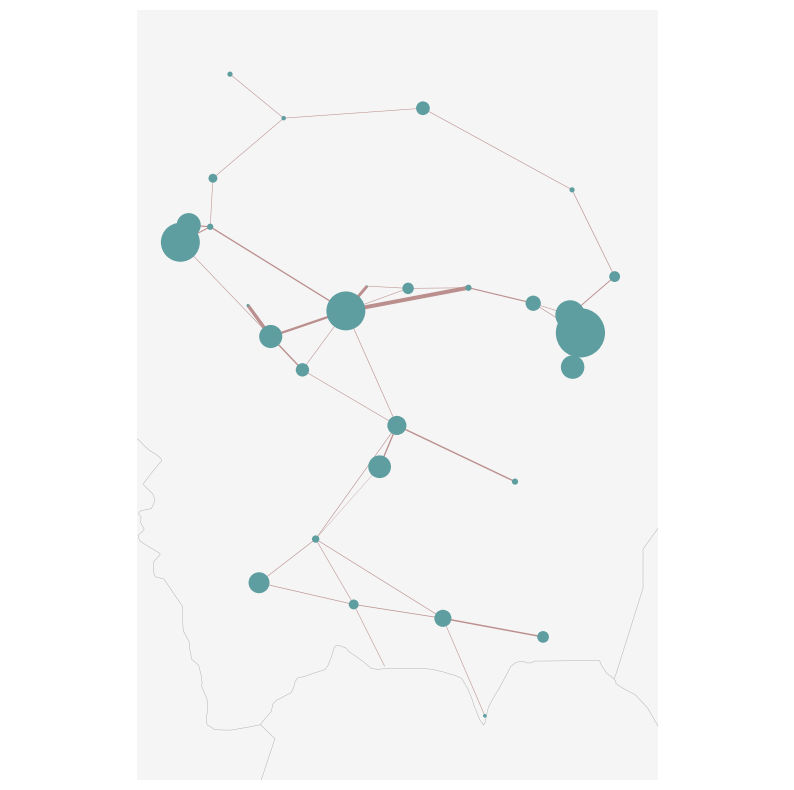

In [59]:
max_node_size = 0.1  # maximum size of a node for plotting purposes [used in plots]

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n = networks[first_year]

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")
plt.show()

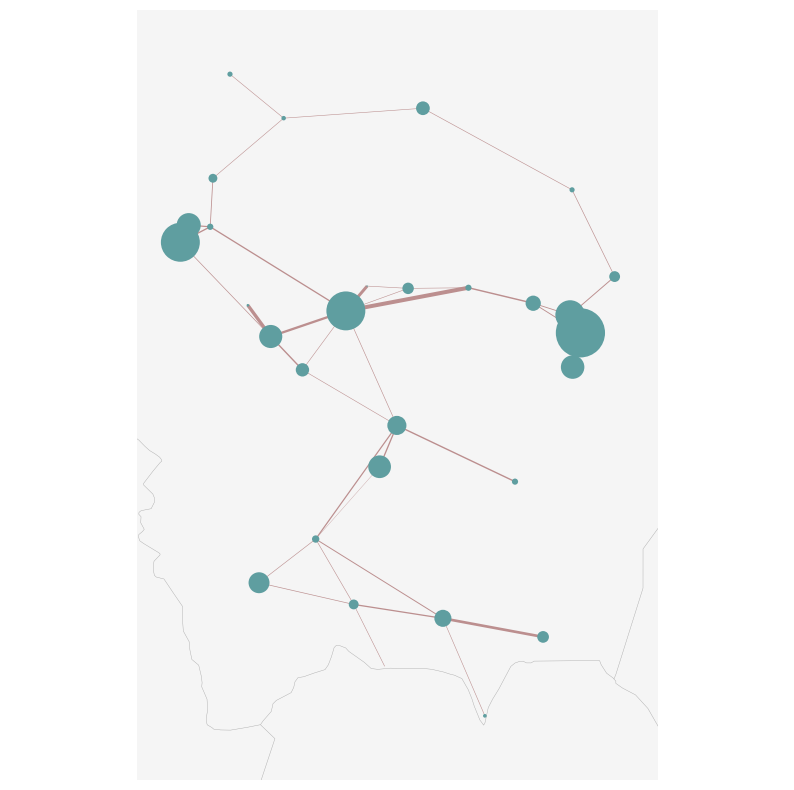

In [60]:

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n = networks[final_year]

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")
plt.show()

In [61]:
n.loads_t.p_set.sum().rename("load").rename_axis("bus")

bus
BO0 0     2.702628e+06
BO0 1     4.315033e+06
BO0 10    3.348455e+05
BO0 11    1.549259e+06
BO0 12    1.730543e+05
BO0 13    9.190470e+05
BO0 14    3.519404e+03
BO0 15    1.398294e+05
BO0 16    4.732496e+04
BO0 17    6.785906e+04
BO0 18    1.177746e+04
BO0 19    9.832821e+05
BO0 2     5.189554e+05
BO0 20    2.418307e+04
BO0 21    3.181099e+05
BO0 23    4.149746e+05
BO0 24    2.338072e+05
BO0 25    9.627629e+04
BO0 26    2.088334e+05
BO0 27    1.035401e+06
BO0 28    4.805609e+04
BO0 29    7.048427e+04
BO0 3     2.704586e+06
BO0 4     7.820613e+05
BO0 5     6.767874e+04
BO0 6     6.504817e+05
BO0 7     2.446026e+05
BO0 8     3.571371e+04
BO0 9     9.523108e+05
Name: load, dtype: float64

In [62]:
# Sum the power generation for each generator over all timesteps
total_generation = n.generators_t.p.sum()

# Create a DataFrame by merging total generation with bus IDs for each generator
gen_to_bus = pd.DataFrame({'generation': total_generation}).merge(n.generators[['bus']], left_index=True, right_on='Generator')

# Group by 'bus' and sum the generation, resulting in a Series
gen_per_bus = gen_to_bus.groupby('bus')['generation'].sum()

# The result is a Series with 'bus' as the index and the summed generation as the values
print(gen_per_bus)

bus
BO0 0     9.668470e+05
BO0 1     9.306765e+05
BO0 10    2.367725e+03
BO0 11    4.601802e+06
BO0 12    8.206291e-01
BO0 13    6.565665e-01
BO0 14    8.640254e+05
BO0 15    6.259102e+05
BO0 16    4.450828e-01
BO0 17    6.141403e-01
BO0 18    1.944862e+05
BO0 19    9.971871e-01
BO0 2     3.660146e-01
BO0 20    4.136136e-01
BO0 21    5.763157e-01
BO0 22    8.821217e-01
BO0 23    6.100339e+05
BO0 24    7.089344e+03
BO0 25    1.392864e+05
BO0 26    6.388690e-01
BO0 27    4.357256e-01
BO0 28    3.221335e+04
BO0 29    2.097755e+05
BO0 3     7.585355e+05
BO0 4     2.494826e+00
BO0 5     4.737940e+06
BO0 6     2.389875e+03
BO0 7     3.605848e+06
BO0 8     2.153789e+02
BO0 9     7.861540e-01
Name: generation, dtype: float64


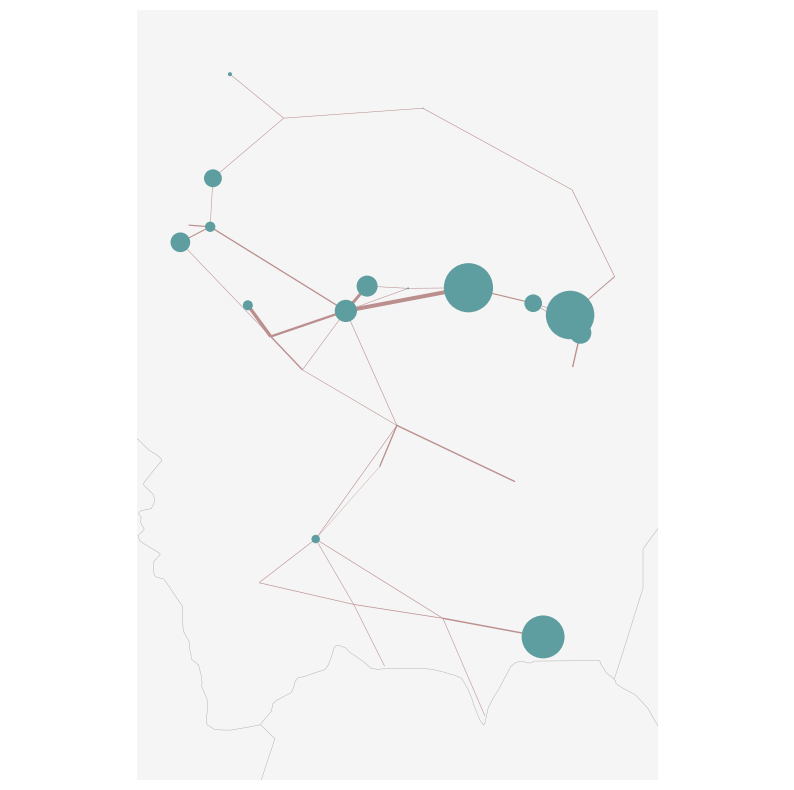

In [63]:

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n = networks[first_year]

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        gen_per_bus
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")
plt.show()

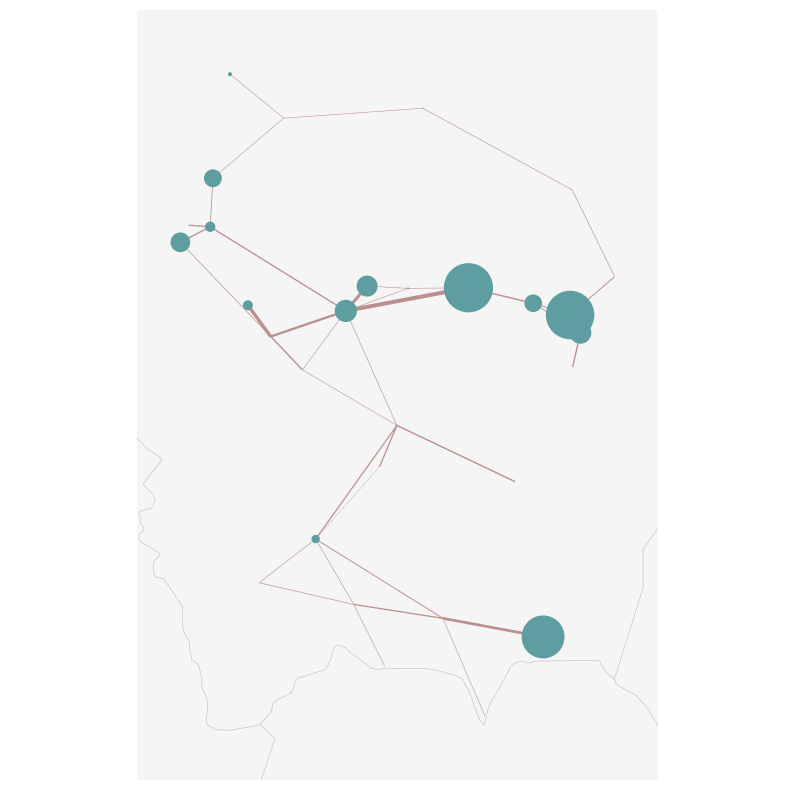

In [64]:

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n = networks[final_year]

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        gen_per_bus
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")
plt.show()

In [65]:
n.generators

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,carrier,p_nom_extendable,bus,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
BO0 0 OCGT,inf,0.000000,39.160823,38132.039653,0.350,39.160823,15.095034,OCGT,True,BO0 0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
BO0 0 onwind,2.049951e+04,185.128881,0.000075,85629.012699,1.000,0.000075,0.025614,onwind,True,BO0 0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
BO0 0 ror,inf,7.540000,7.540000,185442.226463,0.900,0.000000,0.010094,ror,False,BO0 0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
BO0 0 solar,3.486591e+04,6099.364567,0.000267,42888.586621,1.000,0.000267,0.019870,solar,True,BO0 0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
BO0 1 OCGT,inf,0.000000,79.819603,38132.039653,0.350,79.819603,15.096529,OCGT,True,BO0 1,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BO0 8 oil,inf,0.000000,2.152293,29132.039653,0.393,2.152293,39.321022,oil,True,BO0 8,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
BO0 8 onwind,4.620030e+04,2240.576690,0.000203,85629.012699,1.000,0.000203,0.025077,onwind,True,BO0 8,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
BO0 8 solar,3.549854e+04,4852.435726,0.000269,42888.586621,1.000,0.000269,0.020980,solar,True,BO0 8,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


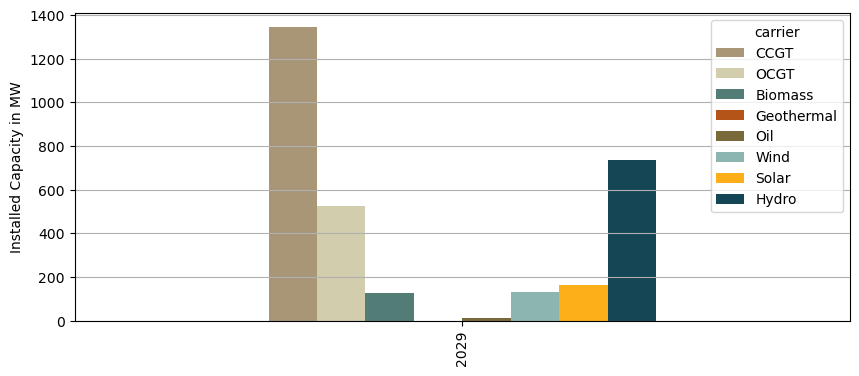

In [66]:
installed_capacity_23 = get_installed_capacity(first_year)
installed_capacity_23.index = [first_year]
installed_capacity_23 = rename_columns(installed_capacity_23)
installed_capacity_23.plot(kind='bar',color=get_colors(installed_capacity_23.columns),figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
#plt.ylim(0,5500)
plt.grid(axis='y')
plt.show()

In [67]:
get_installed_capacity(2029).sum()

carrier
CCGT          1343.070617
OCGT           527.610844
biomass        127.720283
geothermal       0.000104
oil             12.001175
onwind         131.401989
solar          165.084805
hydro          734.850000
dtype: float64

In [68]:
get_installed_capacity(2034).sum()

carrier
CCGT          1343.074510
OCGT           425.978683
biomass        127.721216
geothermal       0.000184
oil            118.464786
onwind         131.404274
solar          165.088915
hydro          732.300000
dtype: float64

In [69]:
get_installed_capacity(2034).sum()

carrier
CCGT          1343.074510
OCGT           425.978683
biomass        127.721216
geothermal       0.000184
oil            118.464786
onwind         131.404274
solar          165.088915
hydro          732.300000
dtype: float64

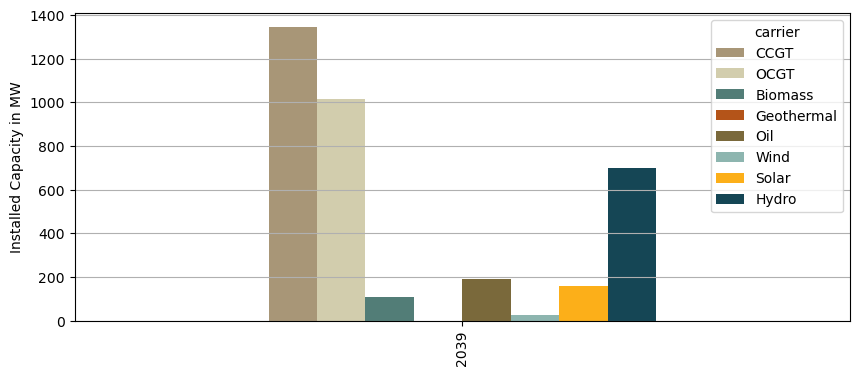

carrier,CCGT,OCGT,Biomass,Geothermal,Oil,Wind,Solar,Hydro
2039,1343.080096,1013.439384,106.722134,0.000292,193.024282,27.007038,160.094675,701.57


In [70]:
installed_capacity_37 = get_installed_capacity(2039)
installed_capacity_37.index = [final_year]
installed_capacity_37 = rename_columns(installed_capacity_37)
if save_to_csv:
    installed_capacity_37.to_csv(path + 'result_data/' + case_path + '_final_capacity.csv')
installed_capacity_37.plot(kind='bar',color=get_colors(installed_capacity_37.columns),figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.grid(axis='y')
#plt.ylim(0,5500)
plt.show()

installed_capacity_37

In [71]:
print(get_installed_capacity(2029))
print(get_installed_capacity(2034))
print(get_installed_capacity(2039))

carrier         CCGT        OCGT     biomass  geothermal        oil  \
2029     1343.070617  527.610844  127.720283    0.000104  12.001175   

carrier      onwind       solar   hydro  
2029     131.401989  165.084805  734.85  
carrier        CCGT        OCGT     biomass  geothermal         oil  \
2034     1343.07451  425.978683  127.721216    0.000184  118.464786   

carrier      onwind       solar  hydro  
2034     131.404274  165.088915  732.3  
carrier         CCGT         OCGT     biomass  geothermal         oil  \
2039     1343.080096  1013.439384  106.722134    0.000292  193.024282   

carrier     onwind       solar   hydro  
2039     27.007038  160.094675  701.57  


In [72]:
yearly_difference = False
if yearly_difference:
    installed_capacities = []
    for year in years:
        year_capacity_df = get_installed_capacity(year)
        installed_capacities.append(year_capacity_df)

    all_capacities = pd.concat(installed_capacities)
    year_over_year_diff = all_capacities.diff().dropna()
    year_over_year_diff = rename_columns(year_over_year_diff)

    year_over_year_diff.plot(kind='bar', figsize=(12, 6), color=get_colors(year_over_year_diff.columns))
    plt.title('Year-over-Year Differences in Installed Capacity')
    plt.ylabel('Difference in Installed Capacity (MW)')
    plt.xlabel('Year')
    #plt.ylim(0, 10)
    plt.show()

carrier
CCGT            0.010095
OCGT          672.519379
Biomass         0.002133
Geothermal      0.000291
Hydro           0.000000
Oil           186.564281
Wind            0.007030
Solar           0.014653
dtype: float64


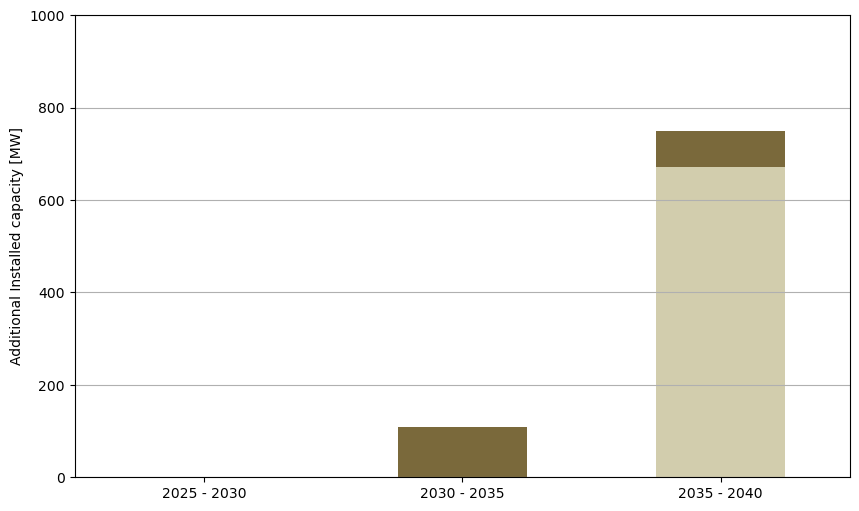

In [73]:
years = [2029, 2034, 2039]
grouped_cap_change_B = get_new_installed(years)
grouped_cap_change_B = rename_columns(grouped_cap_change_B)
grouped_cap_change_B.index = ['2025 - 2030', '2030 - 2035', '2035 - 2040']

if save_to_csv:
    grouped_cap_change_B.to_csv(path + 'result_data/' + case_path + '_new_capacity.csv')
grouped_cap_change_B.plot.bar(stacked=True, figsize=(10, 6),color=get_colors(grouped_cap_change_B.columns), legend=False)

plt.ylabel('Additional Installed capacity [MW]')
plt.xlabel('')
plt.xticks(range(len(grouped_cap_change_B.index)), grouped_cap_change_B.index, rotation=0)
#plt.title(case)
plt.ylim(0, 1000)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis = 'y',zorder = 0)
#plt.savefig(path_fig + 'new_capacity.png', dpi=300, bbox_inches='tight')

print(grouped_cap_change_B.sum())

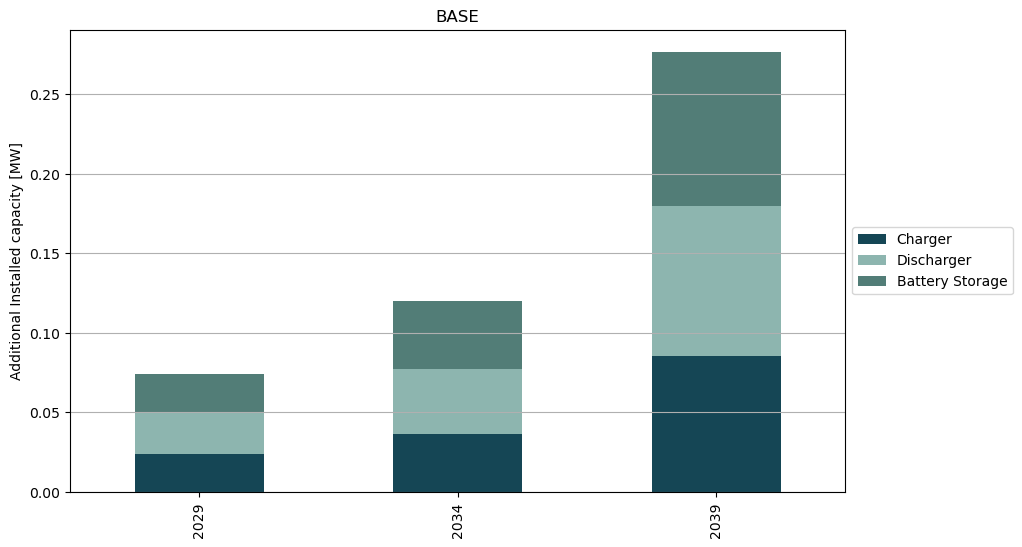

In [74]:
battery_change = get_new_installed_battery(years)
if save_to_csv:
    battery_change.to_csv(path + 'result_data/' + case_path + '_new_battery_capacity.csv')
#battery_change = rename_columns(battery_change)
battery_change.plot.bar(stacked=True, figsize=(10, 6),color=[teal2, teal4, teal3])

plt.ylabel('Additional Installed capacity [MW]')
plt.xlabel('')
plt.xticks(range(len(battery_change.index)), battery_change.index, rotation=90)
plt.title(case)
#plt.ylim(0, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis = 'y',zorder = 0)
#plt.savefig(path_fig + 'new_battery_capacity.png', dpi=300, bbox_inches='tight')

In [75]:
years= [2029, 2034, 2039]

CCGT          31.199703
OCGT           4.507495
Oil            0.009473
Geothermal     0.000004
Hydro          9.841608
Wind           0.408837
Solar          0.881708
Biomass        2.284236
dtype: float32

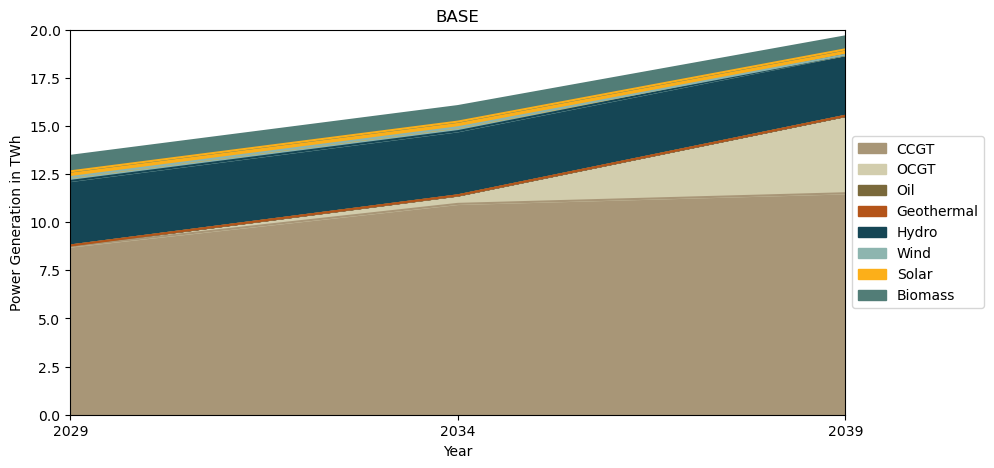

In [76]:
production_sources = [get_power_prod(year) for year in years]
production = pd.concat(production_sources)
production.index = years
production = production.astype('float32')

if 'load' in production:
  production.drop('load', axis=1, inplace=True)

#production['hydro'] += production.pop('ror')
#print(production)
production = rename_columns(production)
if save_to_csv:
  production.to_csv(path + 'result_data/' + case_path + '_production.csv')
production.plot.area(stacked=True, color=get_colors(production.columns),figsize=(10, 5))

plt.xticks(years, [int(year) for year in years])
plt.ylabel('Power Generation in TWh')
plt.xlabel('Year')
plt.xlim(2029,final_year)
plt.ylim(0,20)
plt.title(case)
#plt.xticks(range(len(years)), years)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig(path_fig + 'power_generation.png', dpi=300, bbox_inches='tight')


production.sum()


In [77]:
storage_units = networks[2029].storage_units

          CCGT      OCGT       oil    geothermal     hydro    onwind  \
2029  0.650115  0.003621  0.000003  5.394339e-08  0.249369  0.014938   

         solar   biomass  
2029  0.022048  0.059906  


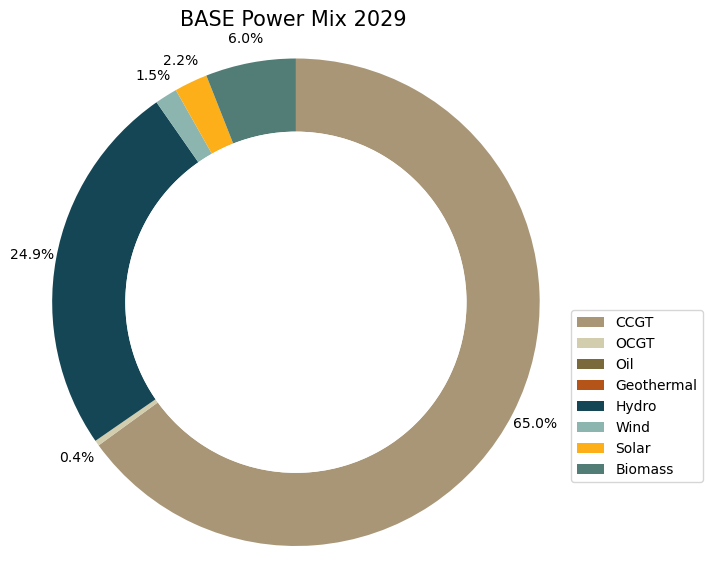

In [78]:
power_mix_df = get_power_mix(first_year)
print(power_mix_df)
plt.rcParams['font.size'] = 10
power_mix_df = rename_columns(power_mix_df)
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(power_mix_df.iloc[0].values, autopct=custom_autopct, colors=get_colors(power_mix_df.columns), startangle=90, counterclock=False, wedgeprops=dict(width=0.3), pctdistance=1.1)

# Hide the zero-value autotexts
for autotext in autotexts:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)

ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title(case + ' Power Mix '+ str(first_year), fontsize=15)
plt.legend(power_mix_df.columns, bbox_to_anchor=(1, 0.5))
plt.show()

3157314.455389326


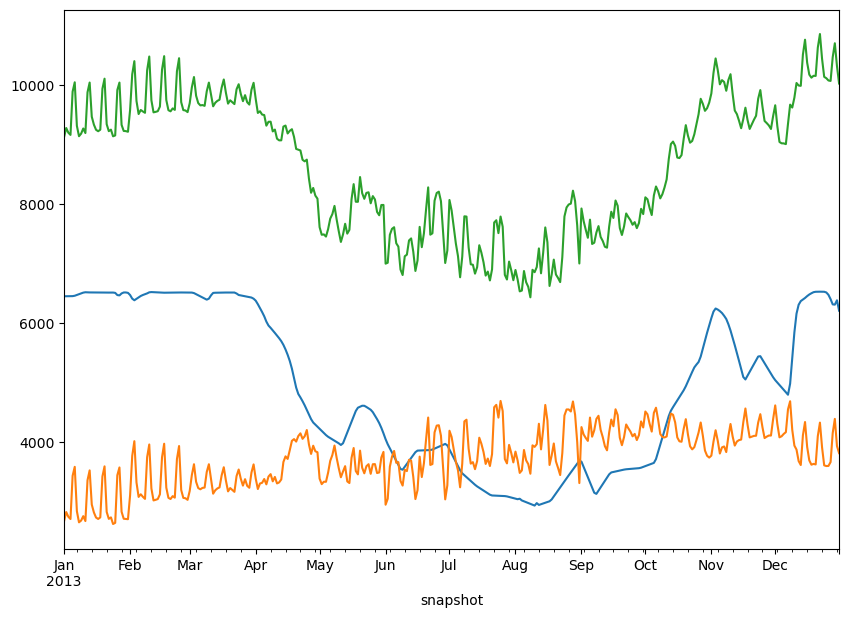

In [79]:
# ror_prod = get_snapshot_generation(first_year, "2013-01-01", "2013-12-31", "ror")
# ror_prod.plot(figsize=(10, 7))
# hydro_prod = get_snapshot_generation(first_year, "2013-01-01", "2013-12-31", "hydro")
# hydro_prod.plot(figsize=(10, 7))
# prod_water = (ror_prod + hydro_prod)
# prod_water.plot(figsize=(10, 7))

inflow_year = final_year

ror_prod = get_snapshot_generation(inflow_year, "2013-01-01", "2013-12-31", "ror").resample('D').sum()
ror_prod.plot(figsize=(10, 7))

hydro_prod = get_snapshot_generation(inflow_year, "2013-01-01", "2013-12-31", "hydro").resample('D').sum()
hydro_prod.plot(figsize=(10, 7))

prod_water = (ror_prod + hydro_prod)
prod_water.plot(figsize=(10, 7))

print(prod_water.sum()) 

In [81]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('../resources/renewable_profiles/inflows_long.csv')

# Sum up the inflows
total_inflows = df['inflow'].sum()

# Print the total inflows
print('Total Inflows:', total_inflows)


Total Inflows: 2228648.476344289


         CCGT      OCGT       oil    geothermal     hydro    onwind     solar  \
2039  0.58535  0.204538  0.000165  9.302883e-08  0.160645  0.000361  0.014693   

       biomass  
2039  0.034248  


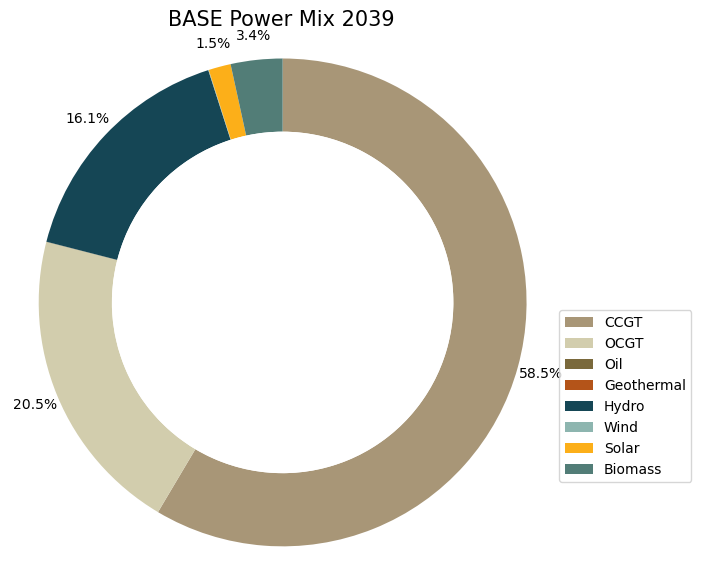

In [82]:
power_mix_df = get_power_mix(final_year)
print(power_mix_df)
plt.rcParams['font.size'] = 10
power_mix_df = rename_columns(power_mix_df)
if save_to_csv:
    try:
        df = pd.read_csv(path + 'result_data/power_mix_final.csv')
    except FileNotFoundError:
        df = pd.DataFrame()
    df[case_path] = power_mix_df.iloc[0]
    df.to_csv(path + 'result_data/power_mix_final.csv', index=False)
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(power_mix_df.iloc[0].values, autopct=custom_autopct, colors=get_colors(power_mix_df.columns), startangle=90, counterclock=False, wedgeprops=dict(width=0.3), pctdistance=1.1)

# Hide the zero-value autotexts
for autotext in autotexts:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)

ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

plt.title(case + ' Power Mix ' + str(final_year), fontsize=15)
plt.legend(power_mix_df.columns, bbox_to_anchor=(1, 0.5))
#plt.savefig(path_fig + 'power_mix_37.png', dpi=300, bbox_inches='tight')
plt.show()

          CCGT      OCGT       oil    geothermal     hydro    onwind  \
2029  0.650115  0.003621  0.000003  5.394339e-08  0.249369  0.014938   

         solar   biomass  
2029  0.022048  0.059906  
          CCGT      OCGT       oil    geothermal     hydro    onwind  \
2034  0.683202  0.027371  0.000385  6.852813e-08  0.207774  0.012529   

         solar   biomass  
2034  0.018491  0.050247  
         CCGT      OCGT       oil    geothermal     hydro    onwind     solar  \
2039  0.58535  0.204538  0.000165  9.302883e-08  0.160645  0.000361  0.014693   

       biomass  
2039  0.034248  


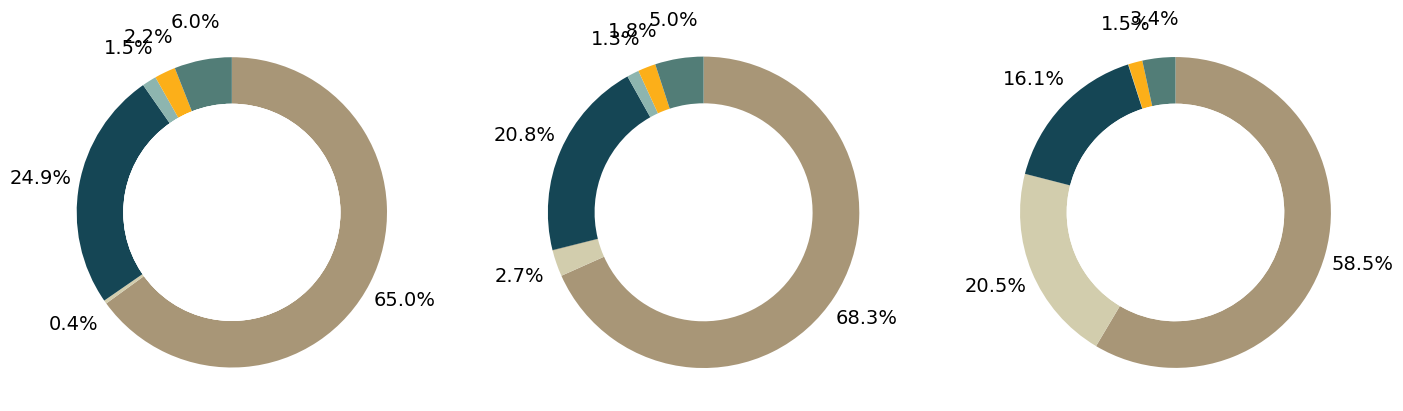

In [83]:
power_mix_first = get_power_mix(2029)
power_mix_middle = get_power_mix(2034)
power_mix_final = get_power_mix(2039) 
print(power_mix_first)
print(power_mix_middle)
print(power_mix_final)

plt.rcParams['font.size'] = 14
power_mix_first = rename_columns(power_mix_first)
power_mix_middle = rename_columns(power_mix_middle)
power_mix_final = rename_columns(power_mix_final)

fig, (ax1, ax15, ax2) = plt.subplots(1, 3, figsize=(15, 5))

textprops={'fontsize': 20}

wedges1, texts1, autotexts1 = ax1.pie(
    power_mix_first.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(power_mix_first.columns), startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.25,
    #textprops=textprops
)

wedges15, texts15, autotexts15 = ax15.pie(
    power_mix_middle.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(power_mix_middle.columns), startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.25,
    #textprops=textprops
)

wedges2, texts2, autotexts2 = ax2.pie(
    power_mix_final.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(power_mix_final.columns), startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.25, 
    #textprops=textprops
)

for autotext in autotexts1 + autotexts15 + autotexts2:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)

centre_circle1 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle1)
#ax1.set_title(str(2029) +' Power Mix', fontsize=18, y=1.1)

centre_circle15 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle15)
#ax1.set_title(str(2034) +' Power Mix', fontsize=18, y=1.1)

centre_circle2 = plt.Circle((0,0),0.70,fc='white')
ax2.add_artist(centre_circle2)
#ax2.set_title(str(2039) +' Power Mix', fontsize=18, y=1.1)

ax1.axis('equal')
ax15.axis('equal')
ax2.axis('equal')

#fig.legend(power_mix_first.columns, loc="center right", bbox_to_anchor=(1.1, 0.5), fontsize=18)
plt.tight_layout(pad=3.0)
#fig.suptitle(case, fontsize=25)
#plt.savefig(path_fig + 'power_mix.png', dpi=300, bbox_inches='tight')

In [87]:
Empire_validering = True
discount_rate = 0.04

In [ ]:
if Empire_validering:

    def empire_factor(period,lifetime):
        return (1-(1+discountrate)**-min((3-period+1)*5,lifetime))/(1-(1+discountrate)**-1)

    capital_costs_3 = []

    new_installed_cap = get_new_installed_hydro(years)
    new_installed_bat = get_new_installed_battery(years)
    new_installed_lines = get_new_installed_lines(years)
    capital_cost_lines = capcost_lines(2029)
    capital_cost_by_type = []
    period = 1

    for y in years:

        network = networks[y]
   
        gen_capex = 0
        bat_capex = 0
        line_capex = 0

        if 2029 < y < 2035:
            period = 2
        elif y >= 2035:
            period = 3

        for carrier in new_installed_cap.columns:
            empire_factor_value = empire_factor(period, costs_pivot.at[carrier, 'lifetime'])
            capex_value = new_installed_cap.loc[y, carrier] * capital_cost_df.loc[carrier, 'capital_cost'] * empire_factor_value
            gen_capex += capex_value

        bat_capex += new_installed_bat.loc[y, 'Battery Storage'] * capital_cost_df.loc['battery storage', 'capital_cost'] * empire_factor(period, costs_pivot.at['battery storage', 'lifetime'])
        bat_capex += new_installed_bat.loc[y, 'Charger'] * capital_cost_df.loc['battery inverter', 'capital_cost'] * empire_factor(period, costs_pivot.at['battery inverter', 'lifetime'])
        bat_capex += new_installed_bat.loc[y, 'Discharger'] * capital_cost_df.loc['battery inverter', 'capital_cost'] * empire_factor(period, costs_pivot.at['battery inverter', 'lifetime'])

        for line in new_installed_lines.columns:
            empire_factor_value = empire_factor(period, costs_pivot.at['HVAC overhead', 'lifetime'])
            capex_value = new_installed_lines.loc[y, str(line)] * capital_cost_lines.loc[line, 'capital_cost'] * empire_factor_value
            line_capex += capex_value


        capital_costs_3.append((gen_capex + bat_capex + line_capex)/1e6)
        capital_cost_by_type.append({'Period': y, 'Type': 'Generators', 'Investment': calculate_present_value(gen_capex,y-4,first_year_empire)/1e6})
        capital_cost_by_type.append({'Period': y, 'Type': 'Storage', 'Investment': calculate_present_value(bat_capex,y-4,first_year_empire)/1e6})
        capital_cost_by_type.append({'Period': y, 'Type': 'Transmission Lines', 'Investment': calculate_present_value(line_capex,y-4,first_year_empire)/1e6})


    capital_cost_by_type_df = pd.DataFrame(capital_cost_by_type)
    pv_capital_costs = [calculate_present_value(i, year-4, first_year_empire, 0.04) for i, year in zip(capital_costs_3, years)]

    operational_scalar = sum((1+discountrate)**(-j) for j in list(range(0,5)))
    operational_costs = get_operational_costs(years)
    adjusted_operational_costs = [operational_costs[i]*operational_scalar for i in range(len(operational_costs))]
    pv_operational_costs = [calculate_present_value(i, year-4, first_year_empire, 0.04) for i, year in zip(adjusted_operational_costs, years)]
    opex = [networks[year].statistics.opex().sum()*operational_scalar / 1e6 for year in years]
    pv_opex = [calculate_present_value(i, year-4, first_year_empire, 0.04) for i, year in zip(opex, years)]
    opex_by_type = [networks[year].statistics.opex()*operational_scalar / 1e6 for year in years]
    pv_opex_by_type = [calculate_present_value(i, year-4, first_year_empire, 0.04) for i, year in zip(opex_by_type, years)]

    print('Capital costs: ', sum(pv_capital_costs)/1e3)
    print('Opex: ', sum(pv_opex)/1e3)
    print('Operational costs: ', sum(pv_operational_costs)/1e3)


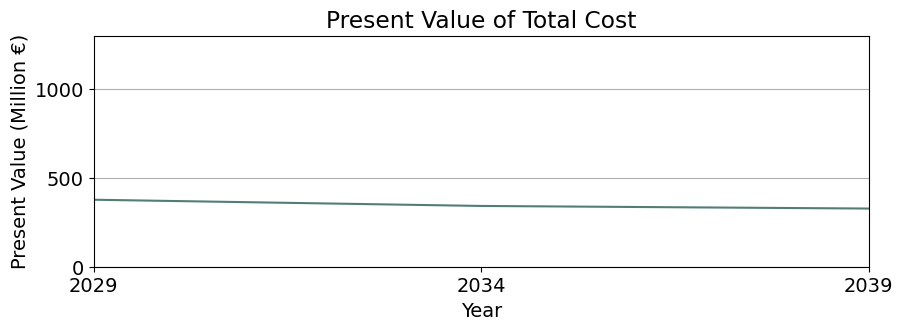

In [84]:
capex = [networks[year].statistics.capex().sum() / 1e6 for year in years]
opex = [networks[year].statistics.opex().sum() / 1e6 for year in years]

pv_capex = [calculate_present_value(cap, year, first_year, 0.04) for cap, year in zip(capex, years)]
pv_opex = [calculate_present_value(o, year, first_year, 0.04) for o, year in zip(opex, years)]

if save_to_csv:
    try:
        capex_df = pd.read_csv(path + 'result_data/capex.csv')
        opex_df = pd.read_csv(path + 'result_data/opex.csv')
    except FileNotFoundError:
        capex_df = pd.DataFrame()
        opex_df = pd.DataFrame()
    
    capex_df[case_path] = pv_capex
    opex_df[case_path] = pv_opex

    capex_df.to_csv(path + 'result_data/capex.csv', index=False)
    opex_df.to_csv(path + 'result_data/opex.csv', index=False)


total_pv = [pv_capex[i] + pv_opex[i] for i in range(len(years))]

plt.figure(figsize=(10, 3))
plt.plot(years, total_pv, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Present Value of Total Cost')
plt.xlabel('Year')
plt.ylabel('Present Value (Million €)')
plt.xlim(first_year,final_year)
plt.ylim(0,1300)
plt.grid(axis='y')
plt.show()

In [ ]:
if save_to_csv:
    total_pv_df = pd.DataFrame(total_pv)
    try:
        df = pd.read_csv(path + 'result_data/total_costs.csv')
    except FileNotFoundError:
        df = pd.DataFrame()
    df[case_path] = total_pv_df.iloc[:]
    df.to_csv(path + 'result_data/total_costs.csv', index=False)

if all_saved:
    df = pd.read_csv(path + 'result_data/total_costs.csv')

    plt.figure(figsize=(10, 6)) 

    num_scenarios = len(df.columns)
    labels = ['Base', 'Base Cap', 'Sudden', 'Sudden Cap', 'Gradual']
    df.columns = labels
    colors = [beige2, beige3, teal4, teal3, teal2]

    for i, column in enumerate(df.columns):
        # Calculate the positions for the current column
        positions = range(i, len(df) * len(df.columns), len(df.columns))
        plt.bar(positions, df[column], width=0.8, label=column, color=colors[i])

    # Set the title and labels
    plt.title('Total Costs for Different Scenarios')
    plt.ylabel('Total Costs [billion €]')

    # Set x-ticks to be in the middle of the group of bars for each scenario
    tick_positions = range(len(df.columns) // 2, len(df) * len(df.columns), len(df.columns))
    plt.xticks(range(num_scenarios), df.columns)

    #plt.legend()
    plt.grid(axis='y')
    plt.ylim(0,8)
    #plt.savefig(path_fig + 'total_cost.png', dpi=300, bbox_inches='tight')
    plt.show()
    
# else:
#     annual_costs_series.plot(kind='bar', figsize=(4, 4), color=teal2)
#     plt.ylabel('Total cost [billion €]')
#     #plt.ylim(0,18)
#     plt.xlabel('Base')
#     plt.grid(axis='y')
#     plt.savefig(path_fig + 'total_cost.png', dpi=300, bbox_inches='tight')

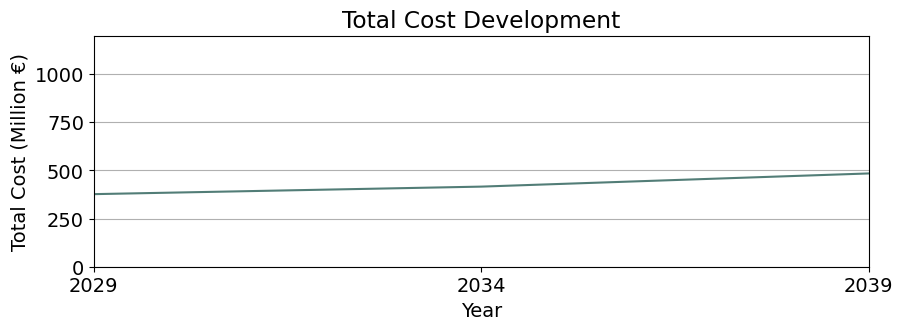

In [85]:
total_costs = [get_total_cost(year).sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_costs, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Total Cost Development')
plt.xlabel('Year')
plt.ylabel('Total Cost (Million €)')
plt.xlim(first_year,final_year)
plt.ylim(0,1200)
plt.grid(axis='y')
plt.show()

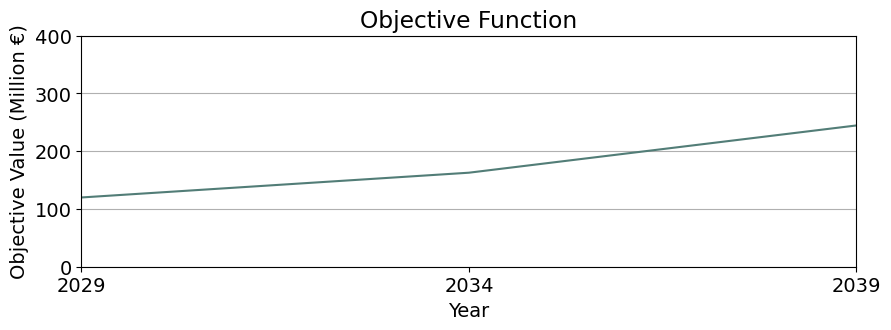

In [86]:
total_objective = [get_objective(year).sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_objective, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Objective Function')
plt.xlabel('Year')
plt.ylabel('Objective Value (Million €)')
plt.xlim(first_year,final_year)
plt.ylim(0,400)
plt.grid(axis='y')
plt.show()

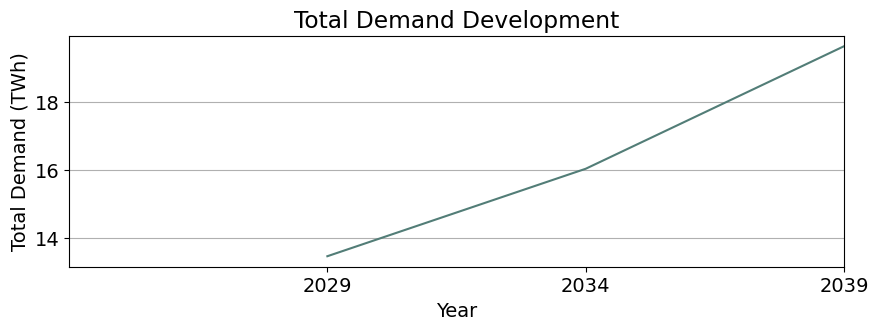

In [ ]:
total_demand = [get_demand(year) for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_demand, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Total Demand Development')
plt.xlabel('Year')
plt.ylabel('Total Demand (TWh)')
plt.xlim(first_year,final_year)
plt.grid(axis='y')
plt.show()

{2029: 3.658873587444635, 2034: 4.78997486778303, 2039: 6.930630894449711}

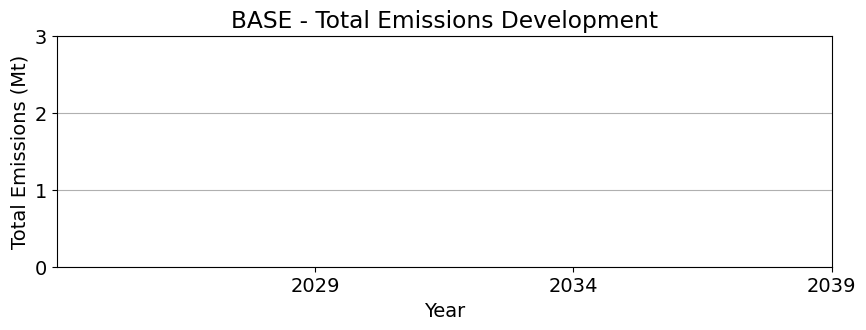

In [ ]:
total_emissions = [get_emissions(year) for year in years]
emissions_dict = {}
for year, emissions in zip(years, total_emissions):
    emissions_dict[year] = emissions

if save_to_csv:
    total_emissions_df = pd.DataFrame({'Year': years, 'Emissions': total_emissions})

    try:
        # Try to read the existing file
        df = pd.read_csv(path + 'result_data/emissions.csv')
    except FileNotFoundError:
        # If file does not exist, create a new DataFrame
        df = pd.DataFrame()
  


    if case_path not in df.columns:
        df[case_path] = total_emissions_df['Emissions']
    df.to_csv(path + 'result_data/emissions.csv', index=False)


if all_saved:
    df = pd.read_csv(path + 'result_data/emissions.csv')
    df = df.set_index('Year')

    labels = ['Base', 'Base Cap', 'Sudden', 'Sudden Cap', 'Gradual']
    df.columns = labels
    colors = [beige2, beige3, teal4, teal3, teal2]

    plt.figure(figsize=(10, 6))  # Adjust the size as needed
    for column in df.columns:
        df[column].plot(label=column, color=colors[df.columns.get_loc(column)])
    plt.title('Emissions Over Years for Different Scenarios')
    plt.xlabel('Year')
    plt.ylabel('Emissions')
    plt.legend()
    plt.grid(axis='y')
    plt.ylim(0,7)
    #plt.savefig(path_fig + 'emissions.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    plt.figure(figsize=(10, 3))
    plt.plot(years, total_emissions, color=teal3)
    plt.xticks(years, [int(year) for year in years])
    plt.title(case + ' - Total Emissions Development')
    plt.xlabel('Year')
    plt.ylabel('Total Emissions (Mt)')
    plt.xlim(first_year,final_year)
    plt.ylim(0,3)
    plt.grid(axis='y')
    #plt.savefig(path_fig + 'emissions.png', dpi=300, bbox_inches='tight')
    
emissions_dict

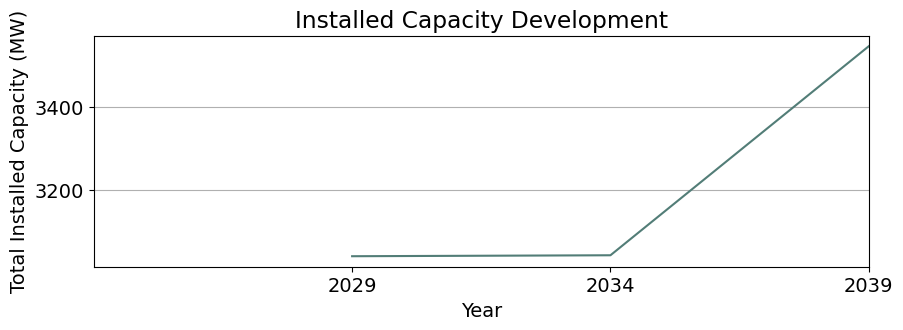

In [ ]:
total_capacity = [get_installed_capacity(year).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_capacity, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Installed Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(first_year,final_year)
#plt.ylim(0,6000)
plt.grid(axis='y')
plt.show()

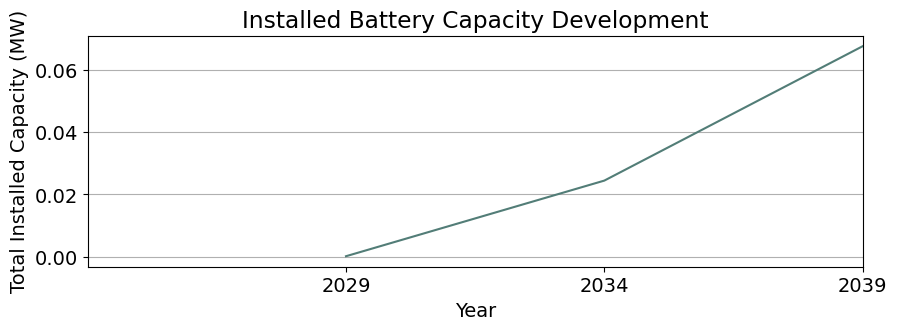

In [ ]:
total_bat_capacity = [get_installed_capacity_battery(year).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_bat_capacity, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Installed Battery Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(first_year,final_year)
#plt.ylim(0,6000)
plt.grid(axis='y')
plt.show()

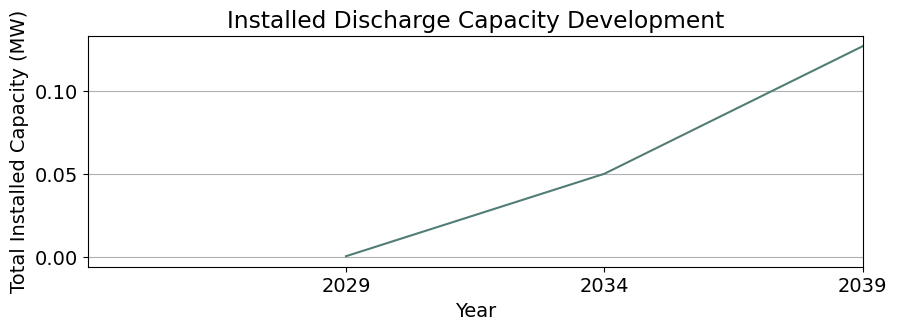

In [ ]:
total_discharge_capacity = [get_installed_capacity_charge(year).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_discharge_capacity, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Installed Discharge Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(first_year,final_year)
#plt.ylim(0,6000)
plt.grid(axis='y')
plt.show()

Text(0.5, 1.0, 'BASE - 2039')

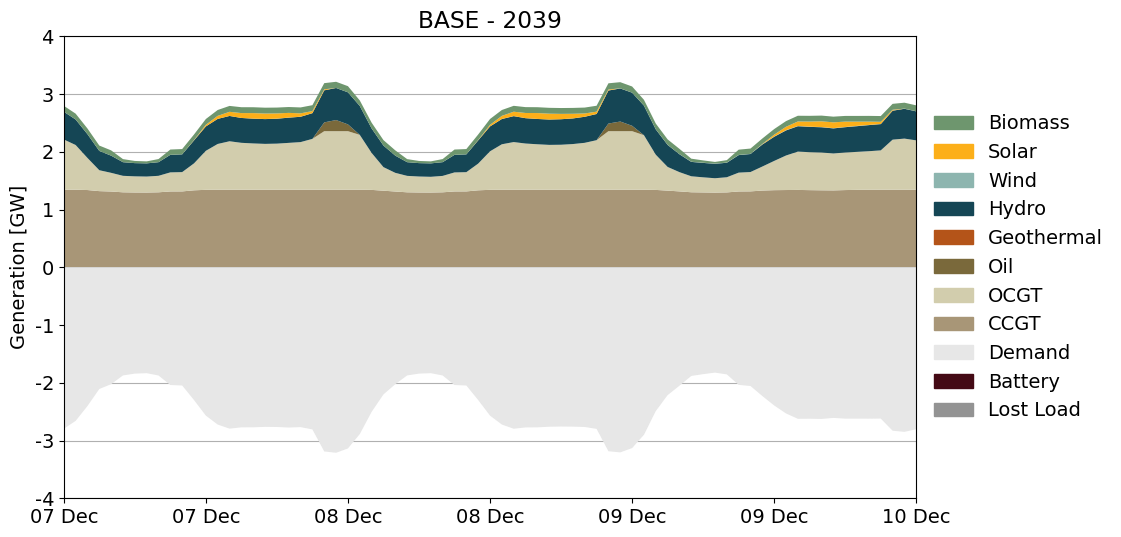

In [ ]:
first_date = "2013-12-07"
second_date = "2013-12-10"
year = 2039

CCGT = get_snapshot_generation(year, first_date, second_date, 'CCGT')
OCGT = get_snapshot_generation(year, first_date, second_date, 'OCGT')
Oil = get_snapshot_generation(year, first_date, second_date, 'oil')
Geothermal = get_snapshot_generation(year, first_date, second_date, 'geothermal')
Hydro = get_snapshot_generation(year, first_date, second_date, 'ror')
Hydro += get_snapshot_generation(year, first_date, second_date, 'hydro')
Wind = get_snapshot_generation(year, first_date, second_date, 'onwind')
Solar = get_snapshot_generation(year, first_date, second_date, 'solar')
Biomass = get_snapshot_generation(year, first_date, second_date, 'biomass')
Battery = get_snapshot_generation(year, first_date, second_date, 'battery')
#H2 = get_snapshot_generation(year, first_date, second_date, 'H2')
demand = get_snapshot_demand(year, first_date, second_date)   

i=0
nbattery = []
pbattery =[]
for i in Battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in Battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 
nbattery_9 = [float(n) / 0.9 for n in nbattery]
pbattery_9 = [float(n) * 0.9 for n in pbattery]
LL = (demand.values + nbattery_9)*-1 - (CCGT + OCGT +Oil +Wind +Solar +Biomass +Hydro +pbattery_9 + Geothermal)

snapshots = {'CCGT': CCGT, 'OCGT': OCGT, 'Oil': Oil,'Geothermal': Geothermal, 'Hydro': Hydro, 'Wind': Wind, 'Solar': Solar, 'Biomass': Biomass, 'Battery': pbattery, 'Nbattery': nbattery, 'Lost load': LL,'Demand': demand}
df_snapshots = pd.DataFrame(snapshots)
if save_to_csv:
    df_snapshots.to_csv(path + 'result_data/' + case_path + '_snapshots.csv')
#print('LL',LL.sum())

# print('CCGT: ', CCGT.sum())
# print('OCGT: ', OCGT.sum())
# print('Wind: ', Wind.sum())
# print('Solar: ', Solar.sum())
# print('Hydro: ', Hydro.sum())
# print('Oil: ', Oil.sum())
# print('Geothermal ',Geothermal.sum())
# print('Biomass: ', Biomass.sum())
# print('Battery: ', Battery.sum())
#print('H2: ', H2.sum())

fig, ax=plt.subplots(figsize = (11,6))
A = plt.stackplot(CCGT.index,CCGT,OCGT,Oil, Geothermal, Hydro, Wind, Solar, Biomass, pbattery, LL,
                  colors=[beige2,beige3,beige1,brown2, teal2, teal4,yellow,green2, brown, grey4], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand,nbattery, colors=[grey1, brown], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d %b')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Generation [GW]')

start_date = pd.to_datetime(first_date)
end_date = pd.to_datetime(second_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-4000, 4000)


biomass_patch = mpatches.Patch(color = green2, label = 'Biomass')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
wind_patch = mpatches.Patch(color=teal4, label ='Wind')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
geo_patch = mpatches.Patch(color = brown2, label = 'Geothermal')
oil_patch = mpatches.Patch(color=beige1, label = 'Oil')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
CCGT_patch = mpatches.Patch(color=beige2, label ='CCGT')
load_patch = mpatches.Patch(color=grey1, label ='Demand')
battery_patch = mpatches.Patch(color=brown, label ='Battery')
LL_patch = mpatches.Patch(color=grey4, label ='Lost Load')
#H2_patch = mpatches.Patch(color=red2, label ='H2')
handles=[biomass_patch, solar_patch, wind_patch, hydro_patch, geo_patch,oil_patch, OCGT_patch, CCGT_patch, load_patch, battery_patch, LL_patch]
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)
plt.title(case + ' - ' + str(year))
#plt.savefig(path_fig + 'snapshot.png', dpi=300, bbox_inches='tight')

In [ ]:
LL.sum()

-0.6232740089171784

Text(0.5, 1.0, 'BASE - 2039')

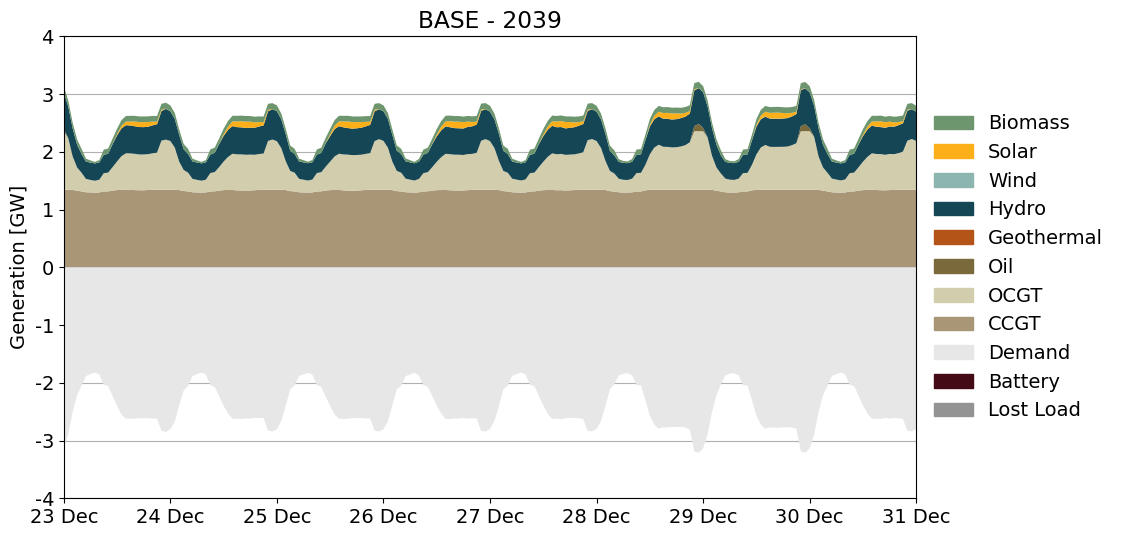

In [ ]:
first_date = "2013-12-23"
second_date = "2013-12-31"
year = 2039

CCGT = get_snapshot_generation(year, first_date, second_date, 'CCGT')
OCGT = get_snapshot_generation(year, first_date, second_date, 'OCGT')
Oil = get_snapshot_generation(year, first_date, second_date, 'oil')
Geothermal = get_snapshot_generation(year, first_date, second_date, 'geothermal')
Hydro = get_snapshot_generation(year, first_date, second_date, 'ror')
Hydro += get_snapshot_generation(year, first_date, second_date, 'hydro')
Wind = get_snapshot_generation(year, first_date, second_date, 'onwind')
Solar = get_snapshot_generation(year, first_date, second_date, 'solar')
Biomass = get_snapshot_generation(year, first_date, second_date, 'biomass')
Battery = get_snapshot_generation(year, first_date, second_date, 'battery')
#H2 = get_snapshot_generation(year, first_date, second_date, 'H2')
demand = get_snapshot_demand(year, first_date, second_date)   

i=0
nbattery = []
pbattery =[]
for i in Battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in Battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 
nbattery_9 = [float(n) / 0.9 for n in nbattery]
pbattery_9 = [float(n) * 0.9 for n in pbattery]
LL = (demand.values + nbattery_9)*-1 - (CCGT + OCGT +Oil +Wind +Solar +Biomass +Hydro +pbattery_9 + Geothermal)

snapshots = {'CCGT': CCGT, 'OCGT': OCGT, 'Oil': Oil,'Geothermal': Geothermal, 'Hydro': Hydro, 'Wind': Wind, 'Solar': Solar, 'Biomass': Biomass, 'Battery': pbattery, 'Nbattery': nbattery, 'Lost load': LL,'Demand': demand}
df_snapshots = pd.DataFrame(snapshots)
if save_to_csv:
    df_snapshots.to_csv(path + 'result_data/' + case_path + '_snapshots.csv')
#print('LL',LL.sum())

# print('CCGT: ', CCGT.sum())
# print('OCGT: ', OCGT.sum())
# print('Wind: ', Wind.sum())
# print('Solar: ', Solar.sum())
# print('Hydro: ', Hydro.sum())
# print('Oil: ', Oil.sum())
# print('Geothermal ',Geothermal.sum())
# print('Biomass: ', Biomass.sum())
# print('Battery: ', Battery.sum())
#print('H2: ', H2.sum())

fig, ax=plt.subplots(figsize = (11,6))
A = plt.stackplot(CCGT.index,CCGT,OCGT,Oil, Geothermal, Hydro, Wind, Solar, Biomass, pbattery, LL,
                  colors=[beige2,beige3,beige1,brown2, teal2, teal4,yellow,green2, brown, grey4], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand,nbattery, colors=[grey1, brown], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d %b')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Generation [GW]')

start_date = pd.to_datetime(first_date)
end_date = pd.to_datetime(second_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-4000, 4000)


biomass_patch = mpatches.Patch(color = green2, label = 'Biomass')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
wind_patch = mpatches.Patch(color=teal4, label ='Wind')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
geo_patch = mpatches.Patch(color = brown2, label = 'Geothermal')
oil_patch = mpatches.Patch(color=beige1, label = 'Oil')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
CCGT_patch = mpatches.Patch(color=beige2, label ='CCGT')
load_patch = mpatches.Patch(color=grey1, label ='Demand')
battery_patch = mpatches.Patch(color=brown, label ='Battery')
LL_patch = mpatches.Patch(color=grey4, label ='Lost Load')
#H2_patch = mpatches.Patch(color=red2, label ='H2')
handles=[biomass_patch, solar_patch, wind_patch, hydro_patch, geo_patch,oil_patch, OCGT_patch, CCGT_patch, load_patch, battery_patch, LL_patch]
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)
plt.title(case + ' - ' + str(year))
#plt.savefig(path_fig + 'snapshot.png', dpi=300, bbox_inches='tight')

In [ ]:
LL.sum()/1000000

-1.3866937713355582e-06

In [ ]:
demand.sum()

-523019.5597397663

In [ ]:
n = networks[2039]

In [ ]:
n.loads_t.p_set.sum().sum()

19653975.377704635

In [ ]:
n.generators_t.p.sum().sum() + n.storage_units_t.p.sum().sum()

19654035.248950735

In [ ]:
total_load_per_hour = n.loads_t.p_set.groupby("snapshot").sum().transpose().sum()

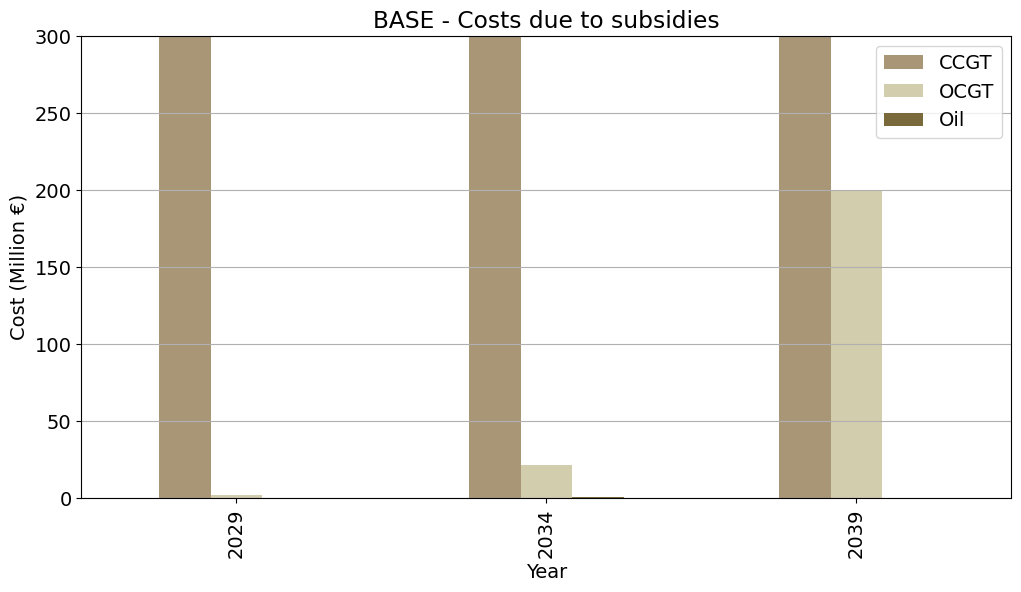

In [ ]:
subsidies = get_subsidies()
cost_of_subsidies = {}

for year in years:
    for (subsidy_year, carrier), subsidy_rate in subsidies.items():
        if carrier == 'oil':
            carrier = 'Oil'
        # Check if we're looking at the correct year for the subsidy
        if subsidy_year == year:
            # Initialize a dictionary for this year if not already present
            if year not in cost_of_subsidies:
                cost_of_subsidies[year] = {}

            cost_of_subsidies[year][carrier] = 0

            # Check if the carrier is present in the production DataFrame
            if carrier in production.columns:
                # Calculate and store the cost of subsidies for this carrier in this year
                cost_of_subsidies[year][carrier] = subsidy_rate * production.loc[year,carrier]

cost_of_subsidies_df = pd.DataFrame()
for year, carriers in cost_of_subsidies.items():
    for carrier, cost in carriers.items():
        cost_of_subsidies_df.loc[year, carrier] = cost
cost_of_subsidies_df = rename_columns(cost_of_subsidies_df)
cost_of_subsidies_df.plot(kind='bar', figsize=(12, 6), color=get_colors(cost_of_subsidies_df.columns))
plt.title(case + ' - Costs due to subsidies')
plt.ylabel('Cost (Million €)')
plt.xlabel('Year')
plt.ylim(0,300)
plt.grid(axis='y')
#plt.savefig(path_fig + 'subsidies.png', dpi=300, bbox_inches='tight')

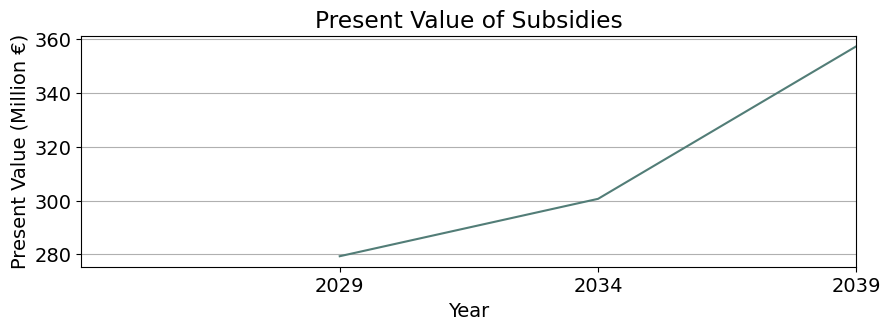

In [ ]:
yearly_subsidies = cost_of_subsidies_df.sum(axis=1)
pv_subsidies = [calculate_present_value(yearly_subsidies.loc[years[i]], years[i], first_year, 0.04) for i in range(len(years))]
npv_subsidies = sum(pv_subsidies)

plt.figure(figsize=(10, 3))
plt.plot(years, pv_subsidies, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Present Value of Subsidies')
plt.xlabel('Year')
plt.ylabel('Present Value (Million €)')
plt.xlim(first_year,final_year)
#plt.ylim(0,300)
plt.grid(axis='y')
plt.show()


In [ ]:
if save_to_csv:
    try:
        # Try to read the existing file
        df = pd.read_csv(path + 'result_data/subsidies.csv')
    except FileNotFoundError:
        # If file does not exist, create a new DataFrame
        df = pd.DataFrame()

    # Add the new data as a column
    df[case_path] = [npv_subsidies]

    # Write the updated DataFrame to the file
    df.to_csv(path + 'result_data/subsidies.csv', index=False)

if all_saved:
    df = pd.read_csv(path + 'result_data/subsidies.csv')

    plt.figure(figsize=(10, 6)) 

    num_scenarios = len(df.columns)
    labels = ['Base', 'Base Cap', 'Sudden', 'Sudden Cap', 'Gradual']
    df.columns = labels
    colors = [beige2, beige3, teal4, teal3, teal2]

    for i, column in enumerate(df.columns):
        # Calculate the positions for the current column
        positions = range(i, len(df) * len(df.columns), len(df.columns))
        plt.bar(positions, df[column], width=0.8, label=column, color=colors[i])

    # Set the title and labels
    plt.title('Total subsidies for Different Scenarios')
    plt.ylabel('Total Subsidies [billion €]')

    # Set x-ticks to be in the middle of the group of bars for each scenario
    tick_positions = range(len(df.columns) // 2, len(df) * len(df.columns), len(df.columns))
    plt.xticks(range(num_scenarios), df.columns)

    #plt.legend()
    plt.grid(axis='y')
    plt.ylim(0,8)
    plt.savefig(path_fig + 'subsidies.png', dpi=300, bbox_inches='tight')
    plt.show()

# else:
#     total_subsidies_series = pd.Series(total_subsidies)
#     total_subsidies_series.plot(kind='bar', figsize=(4, 4), color=teal2)
#     plt.ylabel('Total subsidies [billion €]')
#     #plt.ylim(0,18)
#     plt.xlabel(case_path)
#     plt.grid(axis='y')
#     plt.savefig(path_fig + 'subsidies.png', dpi=300, bbox_inches='tight')

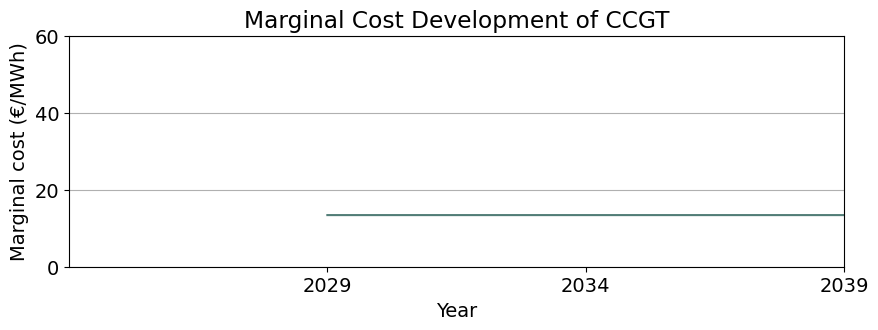

In [ ]:
marginal_cost_CCGT = [get_marginal_cost(year,'CCGT') for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, marginal_cost_CCGT, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Marginal Cost Development of CCGT')
plt.xlabel('Year')
plt.ylabel('Marginal cost (€/MWh)')
plt.xlim(first_year,final_year)
plt.ylim(0,60)
plt.grid(axis='y')
plt.show()

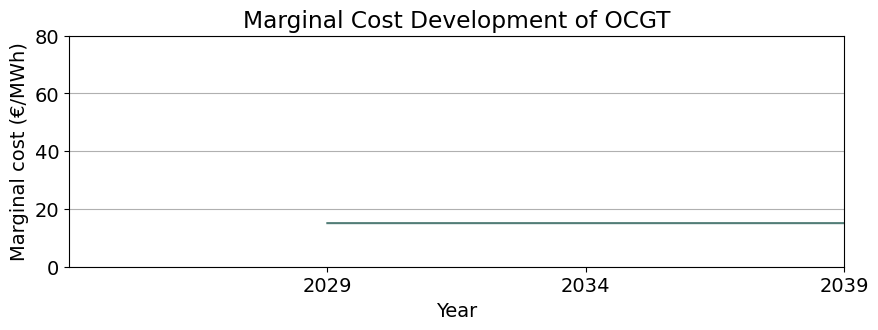

In [ ]:
marginal_cost_OCGT = [get_marginal_cost(year,'OCGT') for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, marginal_cost_OCGT, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Marginal Cost Development of OCGT')
plt.xlabel('Year')
plt.ylabel('Marginal cost (€/MWh)')
plt.xlim(first_year,final_year)
plt.ylim(0,80)
plt.grid(axis='y')
plt.show()

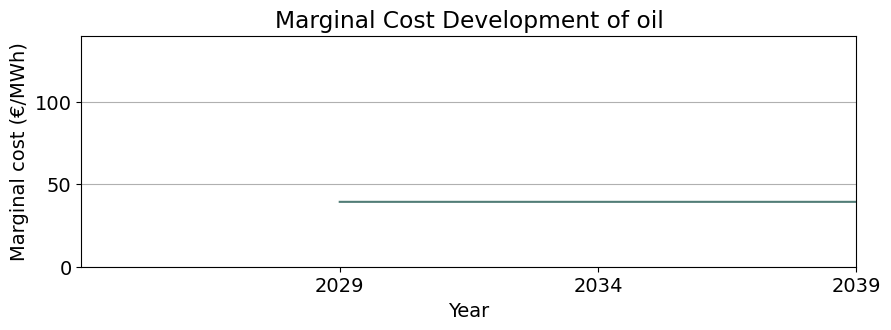

In [ ]:
marginal_cost_oil = [get_marginal_cost(year,'oil') for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, marginal_cost_oil, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Marginal Cost Development of oil')
plt.xlabel('Year')
plt.ylabel('Marginal cost (€/MWh)')
plt.xlim(first_year,final_year)
plt.ylim(0,140)
plt.grid(axis='y')
plt.show()

In [ ]:
# discount_rate = 0.04

# lifetime = {  # example lifetimes in years
#     'hydro': 80,
#     'ror': 80,
#     'OCGT': 30,
#     'CCGT': 30,
#     'geothermal': 40,
#     'biomass': 30,
#     'oil': 30,
#     'solar': 25,
#     'onwind': 30,
#     'electrolysis': 18,
#     'fuel cell': 20,
#     'hydrogen storage': 20,
#     'H2 pipeline': 40,
#     # add lifetimes for all technologies
# }

# annual_costs_list = []

# for year in years:
#     network = networks[year]  # Adjust the path as necessary
#     stats = network.statistics()
#     # Calculate annual Capital Expenditure and Operational Expenditure for all relevant categories
#     annual_capex = 0
#     annual_opex = 0

#     for category in ['Generator', 'Load', 'StorageUnit', 'Store']:
#         if 'Capital Expenditure' in stats.columns:
#             annual_capex += stats.loc[category, 'Capital Expenditure'].sum()
#         if 'Operational Expenditure' in stats.columns:
#             annual_opex += stats.loc[category, 'Operational Expenditure'].sum()
    
#     annual_costs_list.append((annual_capex + annual_opex)/1e9)


# annual_costs_npv = npv_of_costs(annual_costs_list, discount_rate)
# annual_costs_df = pd.DataFrame({'Year': years, 'Cost': annual_costs_list})

# if save_to_csv:
#     try:
#         df = pd.read_csv(path + 'result_dfs/annual_costs.csv')
#     except FileNotFoundError:
#         df = pd.DataFrame()
#     df[case_path] = annual_costs_df['Cost']
#     df.to_csv(path + 'result_dfs/annual_costs.csv', index=False)

# if all_saved:
#     df = pd.read_csv(path + 'result_dfs/annual_costs.csv')
#     df = df.set_index('Year')

#     labels = ['Base', 'Base Cap', 'Sudden', 'Sudden Cap', 'Gradual']
#     df.columns = labels
#     colors = [beige2, beige3, teal4, teal3, teal2]

#     plt.figure(figsize=(10, 6))  # Adjust the size as needed
#     for column in df.columns:
#         df[column].plot(label=column, color=colors[labels.index(column)])
#     plt.title('Annual Costs for Different Scenarios')
#     plt.xlabel('Year')
#     plt.ylabel('Annual Costs [billion €]')
#     plt.legend()
#     plt.grid(axis='y')
#     plt.ylim(0,10)
#     plt.savefig(path_fig + 'annual_cost.png', dpi=300, bbox_inches='tight')
#     plt.show()


# else:
#     plt.figure(figsize=(10, 5))
#     plt.plot(annual_costs_df['Year'], annual_costs_df['Cost'], color=teal2)
#     plt.xticks(years, [int(year) for year in years])
#     plt.title('Base - Annual Costs of the Energy System Over Time')
#     plt.ylabel('Cost [billion €]')
#     plt.xlabel('Year')
#     plt.grid(axis='y')
#     plt.ylim(0,1)
#     plt.savefig(path_fig + 'annual_cost.png', dpi=300, bbox_inches='tight')

In [ ]:
# n = networks[final_year]
# capital_cost_gen = n.generators.groupby('carrier').capital_cost.mean().drop('load')
# capital_cost_gen_series = pd.Series(capital_cost_gen, index=capital_cost_gen.index)
# capital_cost_storage = n.storage_units.groupby('carrier').capital_cost.mean()
# capital_cost_storage_series = pd.Series(capital_cost_storage, index=capital_cost_storage.index)
# capital_cost = pd.concat([capital_cost_gen, capital_cost_storage])

# grouped_cap_change_B = get_new_installed(years)

# i =0.04
# data_add_cost = {}
# carriers = [col for col in grouped_cap_change_B.columns if col != year]
# for carrier in carriers:
#     carrier_values = []

#     for y in np.arange(first_year, final_year+1):
#         value = 0
#         for rest in np.arange(final_year+1-y):
#             if rest > 0:
#                 value += (grouped_cap_change_B[carrier].loc[y] * capital_cost[carrier])/((1+i)**rest)
            
#         carrier_values.append(value)
#     data_add_cost[carrier] = carrier_values

# add_cost_B = pd.DataFrame(data_add_cost, index=np.arange(first_year, final_year+1))

In [ ]:
# objective_value_list_B = []
# for y in range(first_year,final_year):
#     net=networks[y]
#     objective_value_list_B.append(net.objective)

# data={"year":[],"total_costs":[]}
# for y in np.arange(first_year,final_year):
#     data["year"].append(y)
#     data["total_costs"].append(objective_value_list_B[y-first_year]/((1+i)**(y-first_year))+ add_cost_B.sum(axis = 1)[y]/((1+i)**(y-first_year))) #objective_value_B[y]+

# total_costs_B=pd.DataFrame(data)
# total_costs_B.index=total_costs_B["year"]
# total_costs_B.drop("year",axis=1,inplace=True)

In [ ]:
# (total_costs_B['total_costs']/1000000).plot(figsize=(11, 4),color = teal2, linewidth = 4, zorder = 2, label = 'Baseline')
# plt.ylabel('Yearly costs [million €]',fontsize = 18)
# plt.xlabel('Year',fontsize = 18)
# plt.grid(axis='y')
# plt.xlim(first_year,final_year)
# #plt.ylim(0,400)
# plt.legend(frameon = False, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4)


In [ ]:
# total_cost = total_costs_B.sum() / 1e9
# total_cost_series = pd.Series(total_cost.iloc[0], index=[''])
# total_cost_series.plot(kind='bar', figsize=(4, 4), color=teal2)
# plt.ylabel('Total cost [billion €]')
# #plt.ylim(0,18)
# plt.xlabel(case)
# plt.grid(axis='y')
# plt.show()

In [ ]:
storage_units_first = networks[first_year].storage_units
storage_units_final = networks[final_year].storage_units

In [ ]:
networks[2029].loads_t

{'p_set': Load                      BO0 0       BO0 1     BO0 10      BO0 11     BO0 12  \
 snapshot                                                                        
 2013-01-01 00:00:00  230.603939  437.728989  32.832072  126.136074  12.938571   
 2013-01-01 01:00:00  219.332153  416.312597  31.225243  119.960574  12.291042   
 2013-01-01 02:00:00  196.992434  373.923489  28.047559  107.753471  11.031960   
 2013-01-01 03:00:00  173.345668  329.064182  24.678015   94.814900   9.712921   
 2013-01-01 04:00:00  169.676342  322.097260  24.162391   92.812360   9.509070   
 ...                         ...         ...        ...         ...        ...   
 2013-12-31 19:00:00  233.973483  440.427022  31.764850  146.892946  13.981810   
 2013-12-31 20:00:00  234.345212  441.122515  31.812815  147.132771  14.005793   
 2013-12-31 21:00:00  234.441142  441.350349  31.836798  147.204719  14.017784   
 2013-12-31 22:00:00  253.339369  476.916429  34.402928  159.076067  15.144963   
 2013-1

In [ ]:
n.lines.length

Line
1      57.280687
2     128.624883
3     113.555355
4     276.322959
5     213.148129
6     222.200275
7     135.852208
8      36.446634
9      62.604565
10     96.257829
11    295.376348
12    241.067907
13     66.267743
14    102.398127
15    150.493136
16    121.934689
17    132.993338
18    162.488027
19    167.991451
20     79.382900
21     70.094137
22     86.829881
23    162.416552
24    171.338836
25    223.049434
26     68.064722
27    187.594161
28    255.232656
29    169.759437
30    188.248310
31     80.340634
32    113.911849
33    102.999365
34    122.706742
35    244.716559
36     36.954638
37    121.608492
38     58.149798
39    228.324015
Name: length, dtype: float64

In [ ]:
line_snom_24 = networks[2024].lines.s_nom
line_snom_opt_24 = networks[2024].lines.s_nom_opt
# Put line_snom and line_snom_opt in the same DataFrame
line_snom_24 = line_snom_24.rename('s_nom')
line_snom_opt_24 = line_snom_opt_24.rename('s_nom_opt')
line_snom_df_24 = pd.concat([line_snom_24, line_snom_opt_24], axis=1)
line_snom_df_24

,s_nom,s_nom_opt
Line,,
1,644.40,644.400002
2,117.00,117.000001
3,117.00,117.000001
4,280.62,280.620001
5,864.27,864.270002
6,128.25,128.250002
7,497.25,497.250002
8,628.65,628.650003
9,293.40,293.400001


In [ ]:
line_snom = networks[2029].lines.s_nom_opt
line_snom.to_excel('2029linecap_costval_pypsa.xlsx')

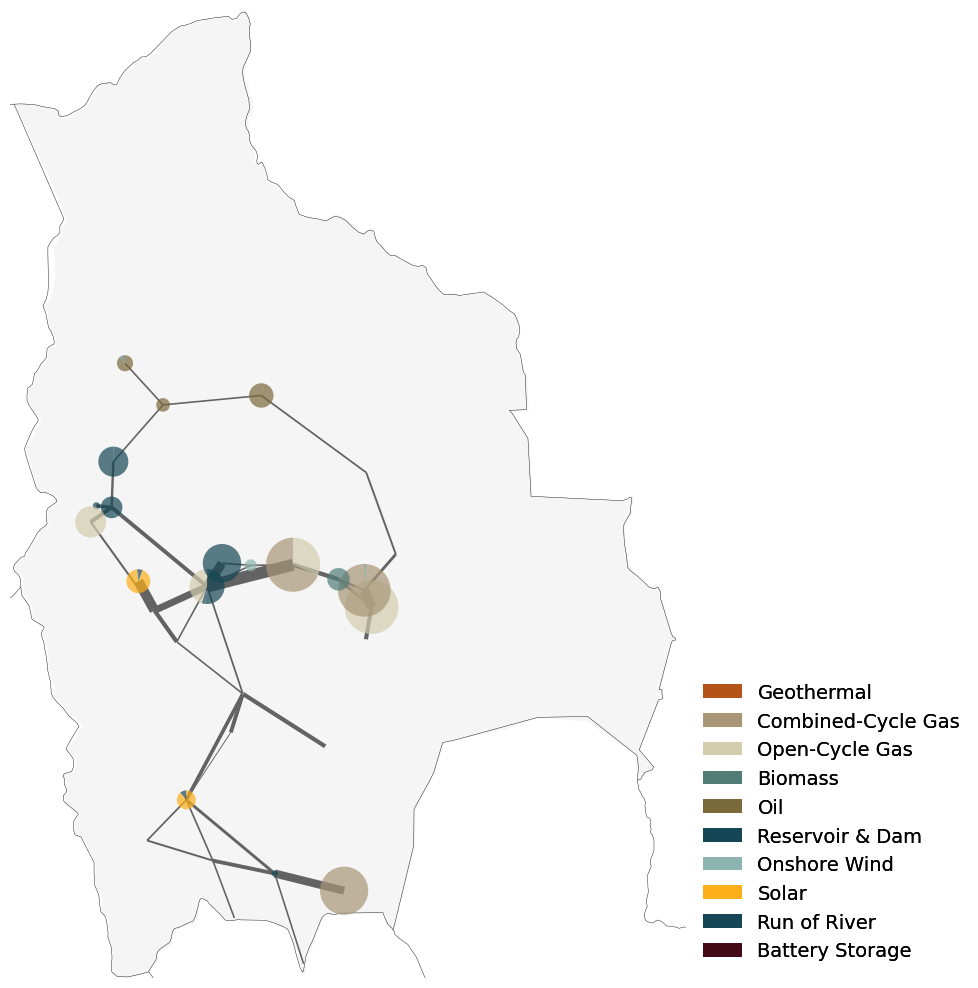

In [ ]:
#network_fin = pypsa.Network('C:/Users/marih/OneDrive/Documents/pypsa-2802/pypsa-earth/base_nze_30_geo/BNZE30_2039.nc')
network_fin = networks[final_year]
n = network_fin

# Remove the PHS and load row in n-carriers
if 'PHS' in n.carriers.index:
    n.carriers = n.carriers.drop(index='PHS')
if 'Load' in n.carriers.index:
    n.carriers = n.carriers.drop(index='Load')
n.carriers.color = [beige3, beige2, teal3, brown2, beige1, teal2, teal4, yellow, teal2, brown]
n.carriers.color['geothermal'] = brown2
n.carriers.color['ror'] = teal2
n.carriers.color['hydro'] = teal2
n.carriers.color['battery'] = brown
n.carriers.color['CCGT'] = beige2
n.carriers.color['OCGT'] = beige3
n.carriers.color['oil'] = beige1
n.carriers.color['onwind'] = teal4
n.carriers.color['solar'] = yellow
n.carriers.color['biomass'] = teal3
n.carriers


bus_scale = 3e3 
line_scale = 1e2

from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

regions_onshore = gpd.read_file(path + "resources/shapes/country_shapes.geojson")

fig, ax = plt.subplots(figsize=(10, 15), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators
gen = gen[~gen['carrier'].str.contains('load')]
gen = gen.groupby(["bus", "carrier"]).p_nom_opt.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
buses = pd.concat([gen, sto])

bus_sizes = buses / bus_scale

line_snom = n.lines.s_nom_opt
line_snom.to_excel('final_linecap_costval_pypsa.xlsx')

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors='#636363',
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
# circles legend may requite some fine-tuning
legend_circles_dict = {"bbox_to_anchor": (1, 0.6), "labelspacing": 5, **legend_kwargs}
bus_sizes = [50, 500, 1000, 1500, 2000]  # in MW
line_sizes = [100, 500, 1000, 1500]  # in MW

# add_legend_circles(
#     ax,
#     [s / bus_scale for s in bus_sizes],
#     [f"{s/1000} GW" for s in bus_sizes],
#     patch_kw={"alpha": 0.8},
#     legend_kw=legend_circles_dict,    
# )
# add_legend_lines(
#     ax,
#     [s / line_scale for s in line_sizes],
#     [f"{s} MW" for s in line_sizes],
#     legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
# )
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)

#plt.title(f"{case} - {final_year}")

fig.tight_layout()



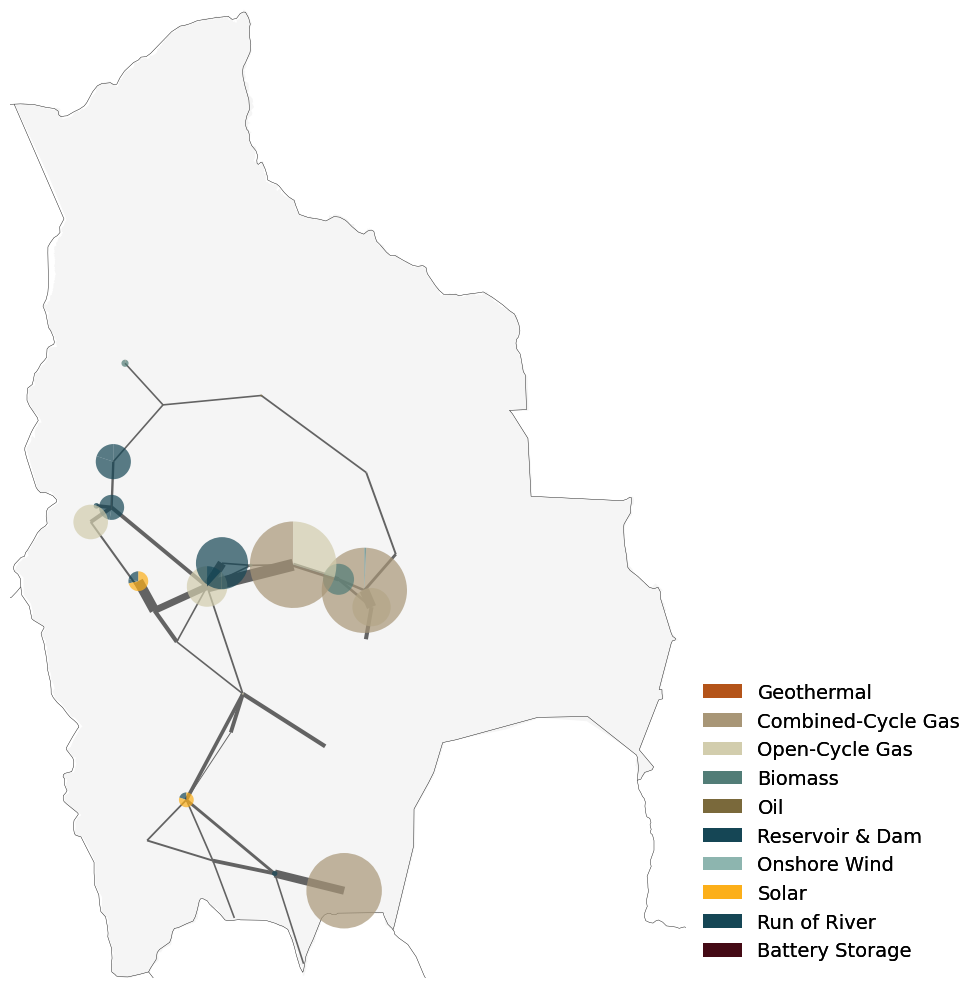

In [ ]:
n = networks[2039]
# Group the production by buses and carriers (without 'load')
# Filter out generators with 'load' in their carrier
filtered_generators = n.generators[~n.generators['carrier'].str.contains('load')]

# Group the generator time series data by bus and carrier, then sum
gen_carrier_node = n.generators_t.p[filtered_generators.index].groupby(
    [n.generators.loc[filtered_generators.index, 'bus'], 
     n.generators.loc[filtered_generators.index, 'carrier']], axis=1).sum().sum()


# Group the storage unit production by buses and carriers
storage_dispatch_node = n.storage_units_t.p.groupby([n.storage_units.bus, n.storage_units.carrier], axis=1).sum().sum()

# Calculate the total production for each bus
total_dispatch_node = gen_carrier_node.add(storage_dispatch_node, fill_value=0)
total_dispatch_node

 
if 'PHS' in n.carriers.index:
    n.carriers = n.carriers.drop(index='PHS')
if 'Load' in n.carriers.index:
    n.carriers = n.carriers.drop(index='Load')
n.carriers.color = [beige3, beige2, teal3, brown2, beige1, teal2, teal4, yellow, teal2, brown]
n.carriers.color['geothermal'] = brown2
n.carriers.color['ror'] = teal2
n.carriers.color['hydro'] = teal2
n.carriers.color['battery'] = brown
n.carriers.color['CCGT'] = beige2
n.carriers.color['OCGT'] = beige3
n.carriers.color['oil'] = beige1
n.carriers.color['onwind'] = teal4
n.carriers.color['solar'] = yellow
n.carriers.color['biomass'] = teal3
n.carriers
 
 
bus_scale = 3e3
line_scale = 1e2
 
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
 
regions_onshore = gpd.read_file(path + "resources/shapes/country_shapes.geojson")
 
fig, ax = plt.subplots(figsize=(10, 15), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators
gen = gen[~gen['carrier'].str.contains('load')]
gen = gen.groupby(["bus", "carrier"]).p_nom_opt.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
buses = pd.concat([gen, sto])
 
bus_sizes = buses / bus_scale
 
line_snom = n.lines.s_nom
 
with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=total_dispatch_node / 1e7,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors='#636363',
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
# circles legend may requite some fine-tuning
legend_circles_dict = {"bbox_to_anchor": (1, 0.6), "labelspacing": 5, **legend_kwargs}
bus_sizes = [50, 500, 1000, 1500, 2000]  # in MW
line_sizes = [100, 500, 1000, 1500]  # in MW
 
# add_legend_circles(
#     ax,
#     [s / bus_scale for s in bus_sizes],
#     [f"{s/1000} GW" for s in bus_sizes],
#     patch_kw={"alpha": 0.8},
#     legend_kw=legend_circles_dict,    
# )
# add_legend_lines(
#     ax,
#     [s / line_scale for s in line_sizes],
#     [f"{s} MW" for s in line_sizes],
#     legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
# )
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
 
#plt.title(f"{case} - {final_year}")
 
fig.tight_layout()
 